In [3]:
import pandas as pd
from gensim.models import KeyedVectors

# Load original datasets
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test.csv")
#Load the  FastText model for word embeddings 
ft_model = KeyedVectors.load("fasttext_model.kv")




In [2]:
train_sample = train_df.sample(frac=0.03, random_state=42)
val_sample = val_df.sample(frac=0.061, random_state=42)
test_sample = test_df.sample(frac=0.07, random_state=42)


In [3]:
print("Number of unique articles in train_sample:", train_sample['id'].nunique())
print("Number of unique articles in val_sample:", val_sample['id'].nunique())
print("Number of unique articles in test_sample:", test_sample['id'].nunique())


Number of unique articles in train_sample: 8613
Number of unique articles in val_sample: 815
Number of unique articles in test_sample: 804


In [4]:
train_sample['article'].head()

272581    By . Mia De Graaf . Britons flocked to beaches...
772       A couple who weighed a combined 32st were sham...
171868    Video footage shows the heart stopping moment ...
63167     Istanbul, Turkey (CNN) -- About 250 people rac...
68522     By . Daily Mail Reporter . PUBLISHED: . 12:53 ...
Name: article, dtype: object

In [4]:
train_sample = train_sample.reset_index(drop=True)
val_sample = val_sample.reset_index(drop=True)
test_sample = test_sample.reset_index(drop=True)



In [ ]:
import pandas as pd
import spacy
import time
from tqdm import tqdm

# Load spaCy model (optimized for tokenization and lemmatization)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
nlp.add_pipe("sentencizer")  # Add sentence boundary detection

# Load stopwords efficiently
from spacy.lang.en.stop_words import STOP_WORDS
stop_words = STOP_WORDS

# preprocessing function using spaCy
def preprocess(article):
    doc = nlp(article)  # Process the full document with spaCy
    original_sentences = [sent.text.strip() for sent in doc.sents]  # Sentence Tokenization
    
    processed_sentences = []
    filtered_sentences = []
    
    for sent in doc.sents:
        # Tokenize and lemmatize words while removing stopwords
        words = [token.lemma_.lower() for token in sent 
                 if not token.is_stop and token.is_alpha] 
        
        if len(words) < 4:
            continue
        
        # Add to filtered sentences if it's a valid sentence
        filtered_sentences.append(sent.text.strip())  # Add original sentence text
        processed_sentences.append(words)  # Add processed words
    
    return filtered_sentences, processed_sentences

# Time tracking
start_time = time.time()

# Apply preprocessing without parallelization
tqdm.pandas()  # Enable tqdm progress bar for pandas

train_sample["sentence_tokenized"], train_sample["word_tokenized"] = zip(*train_sample["article"].progress_apply(preprocess))
val_sample["sentence_tokenized"], val_sample["word_tokenized"] = zip(*val_sample["article"].progress_apply(preprocess))
test_sample["sentence_tokenized"], test_sample["word_tokenized"] = zip(*test_sample["article"].progress_apply(preprocess))

end_time = time.time()
print(f"Preprocessing Time: {end_time - start_time:.2f} seconds")




100%|██████████| 8613/8613 [10:26<00:00, 13.75it/s]

Preprocessing Time: 626.62 seconds


In [7]:
print("sentence  tokenizationArticle:\n", train_sample['sentence_tokenized'].iloc[0])
print("word tokenization Article:\n", train_sample['word_tokenized'].iloc[0])


sentence  tokenizationArticle:
 ['Britons flocked to beaches across the southern coast yesterday as millions look set to bask in glorious sunshine today.', 'Temperatures soared to 17C in Brighton and Dorset, with people starting their long weekend in deck chairs by the sea.', 'Figures from Asda suggest the unexpected sunshine has also inspired a wave of impromptu barbecues, with sales of sausages and equipment expected to triple those in April.', "Sun's out: Brighton beach was packed with Britons enjoying the unexpected sunshine to start the long weekend as temperatures hit 17C across the south coast .", 'Although frost is set to hit the south tonight - with temperatures dropping to 1C - Britons stocking up for a barbecue will be in luck tomorrow, with forecasters predicting dry and sunny weather across southern England, southern Wales and the south Midlands.', "In Weymouth, Dorset, the sun came out in time for the town's annual kite festival, held on the beach.", 'But the good weather

In [8]:
from gensim import corpora
import gensim
from gensim import corpora
from gensim.models import LdaModel
import numpy as np

# Use only training data to create dictionary (avoid data leakage)
train_corpus = [sentence for doc in train_sample["word_tokenized"] for sentence in doc]
dictionary = corpora.Dictionary(train_corpus)

# Convert text to BoW format
train_bow = [dictionary.doc2bow(sentence) for sentence in train_corpus]
val_bow = [dictionary.doc2bow(sentence) for doc in val_sample["word_tokenized"] for sentence in doc]
test_bow = [dictionary.doc2bow(sentence) for doc in test_sample["word_tokenized"] for sentence in doc]

print("Dictionary created with", len(dictionary), "unique tokens.")
print("Training corpus size:", len(train_bow))
print("Validation corpus size:", len(val_bow))
print("Test corpus size:", len(test_bow))


Dictionary created with 71198 unique tokens.
Training corpus size: 272280
Validation corpus size: 23610
Test corpus size: 23781


In [9]:
dictionary.save('lda_dictionary.dict')


In [10]:
from gensim.models import LdaModel
import numpy as np

# Set number of topics (you can tune this)
num_topics = 10

# Train LDA model on training corpus
lda_model = LdaModel(corpus=train_bow, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)

print("LDA Model Trained Successfully!")


LDA Model Trained Successfully!


In [11]:
lda_model.save('lda_model.model')


In [9]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
import spacy
# Load the saved dictionary and LDA model
dictionary = corpora.Dictionary.load('lda_dictionary.dict')
lda_model = LdaModel.load('lda_model.model')


In [27]:
# Function to aggregate BoW of all sentences in a document
def aggregate_bow(doc_sentences, dictionary):
    doc_bow = []
    for sentence in doc_sentences:
        doc_bow.extend(dictionary.doc2bow(sentence))
    return doc_bow

# Apply to train, val, and test samples
train_bow_docs = [aggregate_bow(doc, dictionary) for doc in train_sample["word_tokenized"]]
val_bow_docs = [aggregate_bow(doc, dictionary) for doc in val_sample["word_tokenized"]]
test_bow_docs = [aggregate_bow(doc, dictionary) for doc in test_sample["word_tokenized"]]


In [ ]:
def get_document_topic_vector(bow):
    topic_distribution = lda_model.get_document_topics(bow, minimum_probability=0)
    return np.array([prob for _, prob in sorted(topic_distribution)])
# Compute document topic vectors using the aggregated BoW
train_sample["topic_vector_D"] = [get_document_topic_vector(doc) for doc in train_bow_docs]
val_sample["topic_vector_D"] = [get_document_topic_vector(doc) for doc in val_bow_docs]
test_sample["topic_vector_D"] = [get_document_topic_vector(doc) for doc in test_bow_docs]


In [29]:
# Function to get word topic vector (average topic distribution over words in sentence)
def get_word_topic_vector(sentence):
    bow = dictionary.doc2bow(sentence)
    topic_distribution = lda_model.get_document_topics(bow, minimum_probability=0)
    return np.array([prob for _, prob in sorted(topic_distribution)])

# Apply word topic vector computation
train_sample["word_topic_vectors"] = [[get_word_topic_vector(sentence) for sentence in doc] for doc in train_sample["word_tokenized"]]
val_sample["word_topic_vectors"] = [[get_word_topic_vector(sentence) for sentence in doc] for doc in val_sample["word_tokenized"]]
test_sample["word_topic_vectors"] = [[get_word_topic_vector(sentence) for sentence in doc] for doc in test_sample["word_tokenized"]]

print("Word-Level Topic Vectors (t_wj) Computed and Stored!")


Word-Level Topic Vectors (t_wj) Computed and Stored!


In [30]:
# Function to compute final topic vectors
def compute_final_topic_vectors(doc_topic_vector, word_topic_vectors):
    return [word_vector + doc_topic_vector for word_vector in word_topic_vectors]

# Compute final topic vectors for each document
train_sample["final_topic_vectors"] = [compute_final_topic_vectors(D, W) for D, W in zip(train_sample["topic_vector_D"], train_sample["word_topic_vectors"])]
# val_sample["final_topic_vectors"] = [compute_final_topic_vectors(D, W) for D, W in zip(val_sample["topic_vector_D"], val_sample["word_topic_vectors"])]
# test_sample["final_topic_vectors"] = [compute_final_topic_vectors(D, W) for D, W in zip(test_sample["topic_vector_D"], test_sample["word_topic_vectors"])]

print("Final Topic Vectors (T_j) Computed and Stored!")


Final Topic Vectors (T_j) Computed and Stored!


In [16]:
def print_sample_topic_vectors(df, num_samples=3):
    """Prints topic vectors for sample documents in a well-structured way."""
    for i in range(num_samples):
        print("\n" + "=" * 80)
        print(f"Sample Document {i+1} (Train)")
        print("=" * 80)

        print(f"Article ID: {df['id'].iloc[i]}")
        print("\nDocument Topic Vector (T_D):")
        print(np.array2string(df["topic_vector_D"].iloc[i], precision=4, separator=", "))

        print("\nWord-Level Topic Vectors (t_wj) (First 3 words):")
        for j, vec in enumerate(df["word_topic_vectors"].iloc[i][:3]):
            print(f"  Word {j+1}: {np.array2string(vec, precision=4, separator=', ')}")

        print("\nFinal Topic Vectors (T_j) (First 3 words):")
        for j, vec in enumerate(df["final_topic_vectors"].iloc[i][:3]):
            print(f"  Word {j+1}: {np.array2string(vec, precision=4, separator=', ')}")

        print("=" * 80)

# Call the function for train_sample
print_sample_topic_vectors(train_sample, num_samples=3)



Sample Document 1 (Train)
Article ID: ed0fed726929c1eeabe6c390e47128dbb7d7a055

Document Topic Vector (T_D):
[0.0494, 0.0276, 0.4348, 0.0375, 0.0729, 0.0799, 0.0716, 0.1147, 0.0885,
 0.0231]

Word-Level Topic Vectors (t_wj) (First 3 words):
  Word 1: [0.1052, 0.0071, 0.7615, 0.0071, 0.0071, 0.0071, 0.0833, 0.0071, 0.0071,
 0.0071]
  Word 2: [0.1578, 0.0083, 0.3508, 0.0083, 0.0083, 0.0083, 0.0996, 0.3418, 0.0083,
 0.0083]
  Word 3: [0.0063, 0.0063, 0.1574, 0.0063, 0.5837, 0.0063, 0.0063, 0.09  , 0.0063,
 0.1314]

Final Topic Vectors (T_j) (First 3 words):
  Word 1: [0.1546, 0.0347, 1.1962, 0.0446, 0.08  , 0.0871, 0.155 , 0.1218, 0.0957,
 0.0302]
  Word 2: [0.2072, 0.0359, 0.7855, 0.0458, 0.0812, 0.0883, 0.1713, 0.4565, 0.0969,
 0.0314]
  Word 3: [0.0557, 0.0339, 0.5922, 0.0437, 0.6566, 0.0862, 0.0779, 0.2047, 0.0948,
 0.1544]

Sample Document 2 (Train)
Article ID: 023cd84001b33aed4ff0f3f5ecb0fdd2151cf543

Document Topic Vector (T_D):
[0.1874, 0.0369, 0.1449, 0.0185, 0.0466, 0.1752, 0.1

In [13]:
from gensim.models import KeyedVectors

# Load the saved FastText model
ft_model = KeyedVectors.load("fasttext_model.kv")


In [31]:
import numpy as np
def get_word_embeddings(word_tokenized_sentences):
    """Returns a list of word embeddings for each tokenized word in a document."""
    embeddings = []
    for sentence in word_tokenized_sentences:
        sentence_embeddings = []
        for word in sentence:
            if word in ft_model:
                sentence_embeddings.append(ft_model[word])
            else:
                sentence_embeddings.append(np.zeros(ft_model.vector_size))  # Zero vector for unknown words
        embeddings.append(sentence_embeddings)
    return embeddings

# Compute and store word embeddings for each dataset
train_sample["word_embeddings"] = train_sample["word_tokenized"].apply(get_word_embeddings)
val_sample["word_embeddings"] = val_sample["word_tokenized"].apply(get_word_embeddings)
test_sample["word_embeddings"] = test_sample["word_tokenized"].apply(get_word_embeddings)



In [19]:
def print_sample_word_embeddings(df, num_samples=3):
    """Prints sample word embeddings for a few documents."""
    for i in range(num_samples):
        print("\n" + "=" * 80)
        print(f"🔹 Sample Document {i+1} (Train)")
        print("=" * 80)

        print(f" **Article ID:** {df['id'].iloc[i]}\n")
        print("🔹 **First 3 Sentences & Word Embeddings:**")
        
        for j, sentence in enumerate(df["word_embeddings"].iloc[i][:3]):  # Print first 3 sentences
            print(f"   **Sentence {j+1}:**")
            for k, word_vector in enumerate(sentence[:3]):  # Print first 3 words per sentence
                print(f"    🔹 Word {k+1}: {np.array2string(word_vector, precision=4, separator=', ')}")

        print("=" * 80)

# Print sample embeddings
print_sample_word_embeddings(train_sample, num_samples=3)



🔹 Sample Document 1 (Train)
 **Article ID:** ed0fed726929c1eeabe6c390e47128dbb7d7a055

🔹 **First 3 Sentences & Word Embeddings:**
   **Sentence 1:**
    🔹 Word 1: [-1.158e-01, -1.000e-01,  2.820e-02,  5.370e-02, -5.300e-03, -5.600e-03,
  3.610e-02,  6.530e-02, -2.190e-02,  1.010e-02,  2.810e-02, -2.760e-02,
 -2.610e-02, -4.210e-02, -3.850e-02,  5.800e-03, -1.000e-04, -8.350e-02,
  1.870e-02,  5.540e-02, -3.200e-03, -3.870e-02,  1.100e-03,  1.850e-02,
 -5.340e-02,  6.280e-02, -3.480e-02, -1.430e-02, -2.360e-02, -6.200e-02,
 -4.400e-03, -7.110e-02,  2.000e-02, -8.440e-02, -1.300e-03,  1.600e-02,
  5.060e-02,  6.030e-02,  4.870e-02,  7.450e-02, -2.530e-02, -1.241e-01,
 -1.140e-02, -1.092e-01, -2.240e-02,  8.370e-02, -5.070e-02, -2.900e-02,
 -1.010e-02, -2.250e-02, -6.560e-02,  1.690e-02,  5.460e-02,  1.870e-02,
 -5.330e-02,  2.220e-02, -2.410e-02, -8.300e-03, -9.540e-02, -1.370e-02,
  6.750e-02, -7.490e-02, -5.880e-02, -6.360e-02,  8.550e-02,  4.690e-02,
 -2.380e-02, -1.400e-03,  5.080e-

In [20]:
def print_sample_word_embeddings(df, num_samples=3):
    """Prints sample word embeddings for a few documents in a structured way."""
    for i in range(num_samples):
        print("\n" + "=" * 80)
        print(f"🔹 Sample Document {i+1} (Train)")
        print("=" * 80)

        print(f" **Article ID:** {df['id'].iloc[i]}\n")
        print("🔹 **First 3 Sentences & Word Embeddings:**")

        for j, sentence in enumerate(df["word_embeddings"].iloc[i][:3]):  # First 3 sentences
            print(f"\n **Sentence {j+1}:**")
            print(f"{'Word':<15}{'Embedding (First 5 Dimensions)':<50}")
            print("-" * 65)

            for k, word_vector in enumerate(sentence[:5]):  # First 5 words per sentence
                short_vector = np.round(word_vector[:5], 4)  # Show only first 5 dimensions
                print(f"🔹 Word {k+1:<2}: {short_vector}")

        print("=" * 80)

# Print sample embeddings in a structured way
print_sample_word_embeddings(train_sample, num_samples=3)



🔹 Sample Document 1 (Train)
 **Article ID:** ed0fed726929c1eeabe6c390e47128dbb7d7a055

🔹 **First 3 Sentences & Word Embeddings:**

 **Sentence 1:**
Word           Embedding (First 5 Dimensions)                    
-----------------------------------------------------------------
🔹 Word 1 : [-0.1158 -0.1     0.0282  0.0537 -0.0053]
🔹 Word 2 : [ 0.04   -0.1593  0.0415 -0.0348  0.0492]
🔹 Word 3 : [ 0.027  -0.0275  0.0816 -0.0062  0.007 ]
🔹 Word 4 : [-0.0248 -0.0296  0.0305  0.0416  0.012 ]
🔹 Word 5 : [-0.0002 -0.0571  0.0895  0.1095 -0.0159]

 **Sentence 2:**
Word           Embedding (First 5 Dimensions)                    
-----------------------------------------------------------------
🔹 Word 1 : [ 0.0193  0.0101  0.0962  0.0235 -0.0358]
🔹 Word 2 : [-0.0879 -0.0853  0.1584  0.0684 -0.077 ]
🔹 Word 3 : [-0.086  -0.0048  0.0357 -0.0361  0.0245]
🔹 Word 4 : [-0.0363  0.0309  0.0919  0.0086 -0.0416]
🔹 Word 5 : [ 0.0252 -0.1712  0.0934 -0.0061  0.0133]

 **Sentence 3:**
Word           Embedd

In [32]:
import numpy as np
import heapq
from rouge_score import rouge_scorer
from tqdm import tqdm

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2"], use_stemmer=True)

def greedy_sentence_selection(sentences, abstractive_summary):
    """
    Greedily selects sentences from the document to maximize ROUGE-1 & ROUGE-2 scores
    when matching with the abstractive summary.
    """
    if not sentences or not abstractive_summary:
        return np.zeros(len(sentences), dtype=int)  # Return zero labels for empty cases

    selected_sentences = []
    labels = np.zeros(len(sentences), dtype=int)  # NumPy array for efficiency

    # Step 1: Precompute ROUGE scores for each sentence
    sentence_scores = {
        sent: scorer.score(sent, abstractive_summary) for sent in sentences
    }

    # Step 2: Use a Max Heap (Priority Queue) to efficiently select sentences
    heap = []
    for sentence, scores in sentence_scores.items():
        rouge_1_f = scores["rouge1"].fmeasure
        rouge_2_f = scores["rouge2"].fmeasure
        heapq.heappush(heap, (-rouge_1_f - rouge_2_f, sentence))  # Max heap (negative scores)

    max_rouge_1, max_rouge_2 = 0, 0

    while heap:
        _, best_sentence = heapq.heappop(heap)  # Get highest ROUGE sentence

        # Form new summary with the selected sentence
        new_summary = " ".join(selected_sentences + [best_sentence])
        scores = scorer.score(new_summary, abstractive_summary)

        rouge_1_f, rouge_2_f = scores["rouge1"].fmeasure, scores["rouge2"].fmeasure

        # Stop if no significant improvement in ROUGE scores
        if rouge_1_f <= max_rouge_1 and rouge_2_f <= max_rouge_2:
            break

        # Accept sentence and update scores
        selected_sentences.append(best_sentence)
        max_rouge_1, max_rouge_2 = rouge_1_f, rouge_2_f

    # Assign labels efficiently using NumPy
    for idx, sentence in enumerate(sentences):
        if sentence in selected_sentences:
            labels[idx] = 1

    return labels

# Apply greedy selection with tqdm progress bar
tqdm.pandas()
train_sample["extractive_labels"] = train_sample.progress_apply(
    lambda row: greedy_sentence_selection(row["sentence_tokenized"], row["highlights"]),
    axis=1
)

# Verify label distribution
train_sample["num_selected"] = train_sample["extractive_labels"].apply(lambda x: sum(x))
print(train_sample["num_selected"].describe())


100%|██████████| 8613/8613 [03:59<00:00, 35.94it/s]


count    8613.000000
mean        2.530593
std         1.156736
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        20.000000
Name: num_selected, dtype: float64


In [33]:
tqdm.pandas()
val_sample["extractive_labels"] = val_sample.progress_apply(
    lambda row: greedy_sentence_selection(row["sentence_tokenized"], row["highlights"]),
    axis=1
)
tqdm.pandas()
test_sample["extractive_labels"] = test_sample.progress_apply(
    lambda row: greedy_sentence_selection(row["sentence_tokenized"], row["highlights"]),
    axis=1
)


100%|██████████| 804/804 [00:21<00:00, 37.39it/s]


In [22]:
for i in range(5):
    selected = np.array(train_sample.iloc[i]["sentence_tokenized"])[train_sample.iloc[i]["extractive_labels"] == 1]
    print(f"Extracted Summary {i+1}: {' '.join(selected)}\n")


Extracted Summary 1: Temperatures soared to 17C in Brighton and Dorset, with people starting their long weekend in deck chairs by the sea. But the good weather has not been enjoyed by all as heavy rain poured down across the north west.

Extracted Summary 2: Margaret Gibson, 37, and her husband, James, 41, from Biddulph, Staffs, started piling on the pounds after the birth of their two children just over a decade ago. By last Christmas Margaret tipped the scales at 12st 5lb and James weighed an unhealthy 20st.

Extracted Summary 3: Sam Smith's Go-Pro vision helmet captured the sudden and brief attack while he was spear fishing on the New South Wales south coast on Friday. Sam was airlifted from Mollymook Beach, on the NSW south coast, to Sydney to undergo the surgery . Mr Smith was fishing when he saw the shark and tried to go down to film it, according to his friend Luke Sisinni, the Milton Ulladulla Times reported. ' Meanwhile, Newcastle beach remains closed for ninth consecutive day

In [34]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

class BiLSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(BiLSTMEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.bilstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
    
    def forward(self, x, lengths):
        packed_input = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        _, (h_fwd, h_bwd) = self.bilstm(packed_input)
        sentence_embedding = torch.cat((h_fwd[-1], h_bwd[-1]), dim=-1)  # Shape: (batch, 2*hidden_dim)
        return sentence_embedding

# Model parameters
topic_input_dim = 10   # LDA topic vector size
word_input_dim = 300   # FastText embedding size
hidden_dim = 128

# Instantiate models
topic_bilstm = BiLSTMEncoder(topic_input_dim, hidden_dim)
word_bilstm = BiLSTMEncoder(word_input_dim, hidden_dim)

# Put models in eval mode and avoid gradient tracking
topic_bilstm.eval()
word_bilstm.eval()

print("Generating sentence-level embeddings for all documents...\n")
all_topic_embeddings = []
all_content_embeddings = []

with torch.no_grad():
    for doc_index in tqdm(range(len(train_sample))):
        sample_sentences = train_sample["sentence_tokenized"].iloc[doc_index]
        topic_vectors = train_sample["final_topic_vectors"].iloc[doc_index]
        word_embeddings = train_sample["word_embeddings"].iloc[doc_index]

        doc_E_Ti = []  # Topic embeddings
        doc_E_Wi = []  # Content embeddings

        for i in range(min(len(sample_sentences), len(topic_vectors), len(word_embeddings))):
            # Convert list of arrays to a single NumPy array before creating the tensor
            topic_array = np.array(topic_vectors[i])
            word_array = np.array(word_embeddings[i])

            topic_tensor = torch.tensor(topic_array, dtype=torch.float32).unsqueeze(0)  # (1, seq_len, topic_dim)
            word_tensor = torch.tensor(word_array, dtype=torch.float32).unsqueeze(0)    # (1, seq_len, word_dim)

            topic_len = topic_tensor.shape[1]
            word_len = word_tensor.shape[1]

            # Forward pass
            E_Ti = topic_bilstm(topic_tensor, lengths=[topic_len])  # (1, 2*hidden_dim)
            E_Wi = word_bilstm(word_tensor, lengths=[word_len])     # (1, 2*hidden_dim)

            doc_E_Ti.append(E_Ti.squeeze(0).numpy())
            doc_E_Wi.append(E_Wi.squeeze(0).numpy())

        all_topic_embeddings.append(doc_E_Ti)
        all_content_embeddings.append(doc_E_Wi)

# Save to DataFrame
train_sample["sentence_topic_embeddings"] = all_topic_embeddings
train_sample["sentence_content_embeddings"] = all_content_embeddings

print("\n✅ Done! Sentence-level topic and content embeddings stored successfully in the DataFrame.")


Generating sentence-level embeddings for all documents...



  0%|          | 0/8613 [00:00<?, ?it/s]

100%|██████████| 8613/8613 [17:50<00:00,  8.04it/s]


✅ Done! Sentence-level topic and content embeddings stored successfully in the DataFrame.


In [35]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

class BiLSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(BiLSTMEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.bilstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
    
    def forward(self, x, lengths):
        packed_input = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        _, (h_fwd, h_bwd) = self.bilstm(packed_input)
        sentence_embedding = torch.cat((h_fwd[-1], h_bwd[-1]), dim=-1)  # Shape: (batch, 2*hidden_dim)
        return sentence_embedding

# Model parameters
topic_input_dim = 10   # Adjust based on your topic vector size
word_input_dim = 300   # Adjust based on your word embedding size
hidden_dim = 128

# Instantiate models
topic_bilstm = BiLSTMEncoder(topic_input_dim, hidden_dim)
word_bilstm = BiLSTMEncoder(word_input_dim, hidden_dim)

# Lists to hold all embeddings for each document
all_topic_embeddings = []
all_content_embeddings = []

print("Generating sentence-level embeddings for all documents...\n")

# Loop through all documents
for doc_index in tqdm(range(len(val_sample))):
    sample_doc_id = val_sample["id"].iloc[doc_index]
    sample_sentences = val_sample["sentence_tokenized"].iloc[doc_index]
    topic_vectors = val_sample["final_topic_vectors"].iloc[doc_index]
    word_embeddings = val_sample["word_embeddings"].iloc[doc_index]

    doc_E_Ti = []  # Topic embeddings
    doc_E_Wi = []  # Content embeddings

    for i, sentence in enumerate(sample_sentences):
        if i >= len(topic_vectors) or i >= len(word_embeddings):
            continue  # Skip if vectors are missing

        topic_tensor = torch.tensor(topic_vectors[i], dtype=torch.float32).unsqueeze(0)  # (1, seq_len, topic_dim)
        word_tensor = torch.tensor(word_embeddings[i], dtype=torch.float32).unsqueeze(0)  # (1, seq_len, word_dim)

        topic_seq_len = topic_tensor.shape[1]
        word_seq_len = word_tensor.shape[1]

        with torch.no_grad():
            E_Ti = topic_bilstm(topic_tensor, lengths=[topic_seq_len])  # Shape: (1, 2*hidden_dim)
            E_Wi = word_bilstm(word_tensor, lengths=[word_seq_len])     # Shape: (1, 2*hidden_dim)

        doc_E_Ti.append(E_Ti.squeeze(0).numpy())
        doc_E_Wi.append(E_Wi.squeeze(0).numpy())

    all_topic_embeddings.append(doc_E_Ti)
    all_content_embeddings.append(doc_E_Wi)

# Save to DataFrame columns
val_sample["sentence_topic_embeddings"] = all_topic_embeddings
val_sample["sentence_content_embeddings"] = all_content_embeddings


print("\n✅ Done! Sentence-level topic and content embeddings stored successfully in the DataFrame.")


Generating sentence-level embeddings for all documents...



100%|██████████| 815/815 [01:47<00:00,  7.55it/s]


✅ Done! Sentence-level topic and content embeddings stored successfully in the DataFrame.


In [21]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

class BiLSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(BiLSTMEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.bilstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
    
    def forward(self, x, lengths):
        packed_input = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        _, (h_fwd, h_bwd) = self.bilstm(packed_input)
        sentence_embedding = torch.cat((h_fwd[-1], h_bwd[-1]), dim=-1)  # Shape: (batch, 2*hidden_dim)
        return sentence_embedding

# Model parameters
topic_input_dim = 10   # Adjust based on your topic vector size
word_input_dim = 300   # Adjust based on your word embedding size
hidden_dim = 128

# Instantiate models
topic_bilstm = BiLSTMEncoder(topic_input_dim, hidden_dim)
word_bilstm = BiLSTMEncoder(word_input_dim, hidden_dim)

# Lists to hold all embeddings for each document
all_topic_embeddings = []
all_content_embeddings = []

print("Generating sentence-level embeddings for all documents...\n")

# Loop through all documents
for doc_index in tqdm(range(len(test_sample))):
    sample_doc_id = test_sample["id"].iloc[doc_index]
    sample_sentences = test_sample["sentence_tokenized"].iloc[doc_index]
    topic_vectors = test_sample["final_topic_vectors"].iloc[doc_index]
    word_embeddings = test_sample["word_embeddings"].iloc[doc_index]

    doc_E_Ti = []  # Topic embeddings
    doc_E_Wi = []  # Content embeddings

    for i, sentence in enumerate(sample_sentences):
        if i >= len(topic_vectors) or i >= len(word_embeddings):
            continue  # Skip if vectors are missing

        topic_tensor = torch.tensor(topic_vectors[i], dtype=torch.float32).unsqueeze(0)  # (1, seq_len, topic_dim)
        word_tensor = torch.tensor(word_embeddings[i], dtype=torch.float32).unsqueeze(0)  # (1, seq_len, word_dim)

        topic_seq_len = topic_tensor.shape[1]
        word_seq_len = word_tensor.shape[1]

        with torch.no_grad():
            E_Ti = topic_bilstm(topic_tensor, lengths=[topic_seq_len])  # Shape: (1, 2*hidden_dim)
            E_Wi = word_bilstm(word_tensor, lengths=[word_seq_len])     # Shape: (1, 2*hidden_dim)

        doc_E_Ti.append(E_Ti.squeeze(0).numpy())
        doc_E_Wi.append(E_Wi.squeeze(0).numpy())

    all_topic_embeddings.append(doc_E_Ti)
    all_content_embeddings.append(doc_E_Wi)

# Save to DataFrame columns
test_sample["sentence_topic_embeddings"] = all_topic_embeddings
test_sample["sentence_content_embeddings"] = all_content_embeddings


print("\n✅ Done! Sentence-level topic and content embeddings stored successfully in the DataFrame.")


Generating sentence-level embeddings for all documents...



  0%|          | 0/804 [00:00<?, ?it/s]

C:\Users\magbu\AppData\Local\Temp\ipykernel_25228\892438475.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  word_tensor = torch.tensor(word_embeddings[i], dtype=torch.float32).unsqueeze(0)  # (1, seq_len, word_dim)
100%|██████████| 804/804 [01:50<00:00,  7.31it/s]


✅ Done! Sentence-level topic and content embeddings stored successfully in the DataFrame.


In [27]:
# Import numpy to print nicely if needed
import numpy as np

# Get sentence topic embeddings from the first document
sample_embeddings = train_sample["sentence_topic_embeddings"].iloc[0]

# Print the number of sentences in the document
print(f"Number of sentences in document 0: {len(sample_embeddings)}")

# Print first 3 sentence topic embeddings from that document
for i, sent_embed in enumerate(sample_embeddings[:3]):
    print(f"\nSentence {i} topic embedding (shape: {np.array(sent_embed).shape}):\n{sent_embed}")


Number of sentences in document 0: 28

Sentence 0 topic embedding (shape: (256,)):
[ 0.07462585  0.00618979  0.03815354  0.059576    0.02186145  0.03688552
  0.008255   -0.00167367  0.07668296 -0.03806764  0.02328133  0.00757079
  0.07031544  0.07254746  0.05293796  0.05733912 -0.0170796   0.09290857
  0.0225431   0.04339723  0.0462895   0.06577938  0.02252163  0.02848611
  0.03571618 -0.00806744  0.04370112  0.04837847  0.06026984 -0.01001922
  0.0406217  -0.01008847  0.03444268  0.06540078  0.03485379 -0.03087853
  0.00709973  0.04173959  0.03834122  0.04756472  0.02839188  0.03376668
 -0.04382224  0.05496038 -0.00974084  0.06388775 -0.0319081  -0.0166603
 -0.02047509  0.02198012  0.01209376  0.06342139  0.00997094  0.05045046
  0.01800292  0.0242408   0.02638723  0.05051657  0.07354352  0.03043777
  0.05147872  0.02095459 -0.0170222   0.07539587  0.00636226  0.03379711
  0.0118093  -0.01742226  0.0616634  -0.00200579  0.05621234  0.04065526
 -0.02201527  0.02712654 -0.00715594  0.00

In [36]:
def generate_labels(sentences, extractive_labels):
    """
    Generate binary labels (1 for important, 0 for not important) for sentences in the article
    based on whether the sentence is part of the extractive summary (1 for important, 0 for not important).
    This function also ensures that the number of labels matches the number of sentences.
    """
    labels = []
    
    # Iterate over the sentences and assign labels from extractive_labels
    for i, sentences in enumerate(sentences):
        # Check if a corresponding label exists
        if i < len(extractive_labels):
            labels.append(extractive_labels[i])
        else:
            # If no label is present, default to 0 (not important)
            labels.append(0)
    
    return labels
train_sample["sentence_labels"] = [
    generate_labels(row["sentence_tokenized"], row["extractive_labels"]) 
    for _, row in train_sample.iterrows()
]


# Check if the binary labels are correctly assigned
print(train_sample[["sentence_tokenized","sentence_labels"]].head())


                                  sentence_tokenized  \
0  [Britons flocked to beaches across the souther...   
1  [A couple who weighed a combined 32st were sha...   
2  [Video footage shows the heart stopping moment...   
3  [Istanbul, Turkey (CNN) -- About 250 people ra...   
4  [An Australian icebreaker carrying passengers ...   

                                     sentence_labels  
0  [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...  
3                  [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]  
4  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  


In [37]:
val_sample["sentence_labels"] = [
    generate_labels(row["sentence_tokenized"], row["extractive_labels"]) 
    for _, row in val_sample.iterrows()
]



In [38]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
from prettytable import PrettyTable
import torch.nn.utils.rnn as rnn_utils
import csv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SentenceSaliencyDataset(Dataset):
    def __init__(self, df):
        self.content_embeddings = df["sentence_content_embeddings"].values
        self.topic_embeddings = df["sentence_topic_embeddings"].values
        self.labels = df["sentence_labels"].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        content = np.array(self.content_embeddings[idx], dtype=np.float32)
        topic = np.array(self.topic_embeddings[idx], dtype=np.float32)
        # Clip labels so they stay in a specific range (useful for BCELoss)
        label = np.clip(np.array(self.labels[idx], dtype=np.float32), 0.05, 0.95)
        return content, topic, label

def collate_fn(batch):
    contents, topics, labels = zip(*batch)
    lengths = [len(x) for x in contents]
    contents_padded = rnn_utils.pad_sequence([torch.tensor(x) for x in contents], batch_first=True)
    topics_padded = rnn_utils.pad_sequence([torch.tensor(x) for x in topics], batch_first=True)
    labels_padded = rnn_utils.pad_sequence([torch.tensor(x) for x in labels], batch_first=True)
    return contents_padded, topics_padded, labels_padded, lengths

class Seq2SeqWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.5):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=2, bidirectional=True,
                               batch_first=True, dropout=dropout)
        self.decoder = nn.LSTM(input_dim, hidden_dim, num_layers=2, bidirectional=True,
                               batch_first=True, dropout=dropout)
        self.attention = nn.Linear(2 * hidden_dim * 2, 1)
        self.mlp_fc1 = nn.Linear(2 * hidden_dim * 2, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.mlp_fc2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, embeddings, lengths):
        # Pack the sequence for variable length processing
        packed = rnn_utils.pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)
        enc_out, _ = self.encoder(packed)
        enc_out, _ = rnn_utils.pad_packed_sequence(enc_out, batch_first=True)
        dec_out, _ = self.decoder(packed)
        dec_out, _ = rnn_utils.pad_packed_sequence(dec_out, batch_first=True)

        # Compute attention weights for each time step
        attn_weights = []
        for i in range(dec_out.size(1)):
            dec_i = dec_out[:, i, :].unsqueeze(1)
            attn_input = torch.cat((dec_i.repeat(1, dec_out.size(1), 1), enc_out), dim=-1)
            attn_score = self.attention(attn_input).squeeze(-1)
            attn_weights.append(torch.softmax(attn_score, dim=-1))
        attn_weights = torch.stack(attn_weights, dim=1)
        context = torch.bmm(attn_weights, enc_out)

        # Concatenate context with decoder outputs then apply the MLP
        mlp_input = torch.cat((context, dec_out), dim=-1)
        B, T, F = mlp_input.shape
        mlp_input = mlp_input.view(B * T, F)
        mlp_out = self.relu(self.bn(self.mlp_fc1(mlp_input)))
        mlp_out = self.dropout(mlp_out)
        scores = self.sigmoid(self.mlp_fc2(mlp_out)).view(B, T)
        return scores

def save_checkpoint(model, optimizer, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

def load_checkpoint(model, optimizer, path):
    if os.path.isfile(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"✅ Loaded checkpoint from {path} (epoch {checkpoint['epoch']})")
        return checkpoint['epoch'] + 1
    return 0




In [ ]:
# Hyperparameters
hidden_dim = 128
embedding_dim = 2 * hidden_dim
batch_size = 16

# Datasets (assuming train_sample and val_sample are defined DataFrames)
train_dataset = SentenceSaliencyDataset(train_sample)
val_dataset = SentenceSaliencyDataset(val_sample)

# Dataloaders with pin_memory for GPU efficiency
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        collate_fn=collate_fn, pin_memory=True)

# Models with different dropout parameters
content_seq2seq = Seq2SeqWithAttention(embedding_dim, hidden_dim, dropout=0.5).to(device)
topic_seq2seq = Seq2SeqWithAttention(embedding_dim, hidden_dim, dropout=0.3).to(device)

# Optimizers
optimizer_content = torch.optim.Adam(content_seq2seq.parameters(), lr=0.0003, weight_decay=1e-5)
optimizer_topic = torch.optim.Adam(topic_seq2seq.parameters(), lr=0.001)

# Learning Rate Schedulers
scheduler_content = torch.optim.lr_scheduler.MultiStepLR(optimizer_content, milestones=[10, 20], gamma=0.1)
scheduler_topic = torch.optim.lr_scheduler.MultiStepLR(optimizer_topic, milestones=[10, 20], gamma=0.1)

# Checkpoints
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
content_checkpoint_path = os.path.join(checkpoint_dir, "content_seq2seq.pth")
topic_checkpoint_path = os.path.join(checkpoint_dir, "topic_seq2seq.pth")
start_epoch_content = load_checkpoint(content_seq2seq, optimizer_content, content_checkpoint_path)
start_epoch_topic = load_checkpoint(topic_seq2seq, optimizer_topic, topic_checkpoint_path)
start_epoch = max(start_epoch_content, start_epoch_topic)

# Logging & early stopping variables
best_content_loss = float('inf')
best_topic_loss = float('inf')
early_stop_counter = 0
early_stop_patience = 7

progress_table = PrettyTable()
progress_table.field_names = ["Epoch", "Train_Content_Loss", "Val_Content_Loss", 
                              "Train_Topic_Loss", "Val_Topic_Loss", "Saved"]

# # CSV Logger Setup
csv_file = 'training_progress.csv'
csv_columns = progress_table.field_names
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(csv_columns)


In [102]:
# Use BCELoss (Binary Cross-Entropy Loss) since the model outputs are passed through a Sigmoid
criterion = nn.BCELoss()

# Training Loop
epochs = 30
for epoch in range(start_epoch, epochs):
    content_seq2seq.train()
    topic_seq2seq.train()
    total_loss_content = 0
    total_loss_topic = 0

    for content_tensor, topic_tensor, label_tensor, lengths in tqdm(train_loader):
        content_tensor = content_tensor.to(device)
        topic_tensor = topic_tensor.to(device)
        label_tensor = label_tensor.to(device)

        # Content Model Training Step
        optimizer_content.zero_grad()
        content_scores = content_seq2seq(content_tensor, lengths)
        loss_content = criterion(content_scores, label_tensor)
        loss_content.backward()
        torch.nn.utils.clip_grad_norm_(content_seq2seq.parameters(), 0.5)
        optimizer_content.step()
        total_loss_content += loss_content.item()

        # Topic Model Training Step
        optimizer_topic.zero_grad()
        topic_scores = topic_seq2seq(topic_tensor, lengths)
        loss_topic = criterion(topic_scores, label_tensor)
        loss_topic.backward()
        torch.nn.utils.clip_grad_norm_(topic_seq2seq.parameters(), 0.5)
        optimizer_topic.step()
        total_loss_topic += loss_topic.item()

    # Validation
    content_seq2seq.eval()
    topic_seq2seq.eval()
    val_loss_content = 0
    val_loss_topic = 0

    with torch.no_grad():
        for content_tensor, topic_tensor, label_tensor, lengths in val_loader:
            content_tensor = content_tensor.to(device)
            topic_tensor = topic_tensor.to(device)
            label_tensor = label_tensor.to(device)

            content_scores = content_seq2seq(content_tensor, lengths)
            topic_scores = topic_seq2seq(topic_tensor, lengths)
            val_loss_content += criterion(content_scores, label_tensor).item()
            val_loss_topic += criterion(topic_scores, label_tensor).item()

    # Step the schedulers
    scheduler_content.step()
    scheduler_topic.step()

    # Checkpoint saving and early stopping logic
    saved = ""
    if val_loss_content < best_content_loss or val_loss_topic < best_topic_loss:
        best_content_loss = min(best_content_loss, val_loss_content)
        best_topic_loss = min(best_topic_loss, val_loss_topic)
        save_checkpoint(content_seq2seq, optimizer_content, epoch, content_checkpoint_path)
        save_checkpoint(topic_seq2seq, optimizer_topic, epoch, topic_checkpoint_path)
        saved = "✅"
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print(f"\n⛔ Early stopping triggered at epoch {epoch+1}")
            break

    # Logging progress with PrettyTable and CSV
    row = [
        epoch + 1,
        f"{total_loss_content:.4f}",
        f"{val_loss_content:.4f}",
        f"{total_loss_topic:.4f}",
        f"{val_loss_topic:.4f}",
        saved
    ]
    progress_table.add_row(row)
    print(progress_table.get_string(start=len(progress_table._rows)-1))  # Print the last row only

    with open(csv_file, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(row)


100%|██████████| 539/539 [14:14<00:00,  1.59s/it]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   1   |      113.3096      |      9.2748      |     100.8068     |     8.9504     |   ✅  |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [08:02<00:00,  1.12it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   2   |      94.7875       |      9.7619      |     93.3053      |     8.9475     |   ✅  |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:08<00:00,  1.26it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   3   |      93.9524       |     10.2555      |     93.1834      |     8.9144     |   ✅  |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:09<00:00,  1.25it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   4   |      92.3636       |      9.9177      |     91.7112      |     8.8734     |   ✅  |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:10<00:00,  1.25it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   5   |      92.0192       |      9.9816      |     91.4959      |     8.9140     |       |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:06<00:00,  1.27it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   6   |      93.0963       |     10.3685      |     92.6928      |     8.8610     |   ✅  |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:07<00:00,  1.26it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   7   |      91.9941       |     10.6630      |     91.6346      |     8.8887     |       |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:07<00:00,  1.26it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   8   |      91.7418       |     10.0388      |     91.4798      |     8.8796     |       |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:10<00:00,  1.25it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   9   |      92.2537       |      9.7620      |     92.0434      |     8.8705     |       |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:09<00:00,  1.26it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   10  |      91.3888       |     10.2459      |     91.2507      |     8.8742     |       |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:06<00:00,  1.26it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   11  |      91.7975       |     10.6419      |     91.7287      |     8.8670     |       |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:07<00:00,  1.26it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   12  |      91.4709       |     10.6694      |     91.4257      |     8.8607     |   ✅  |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:08<00:00,  1.26it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   13  |      90.9019       |     10.8245      |     90.9601      |     8.8614     |       |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:08<00:00,  1.26it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   14  |      90.8924       |     10.9748      |     90.9443      |     8.8743     |       |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:23<00:00,  1.22it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   15  |      91.2341       |     11.1923      |     91.2931      |     8.8673     |       |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:31<00:00,  1.19it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   16  |      90.9687       |     11.0927      |     91.0748      |     8.8604     |   ✅  |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:33<00:00,  1.19it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   17  |      91.1727       |     11.2093      |     91.2628      |     8.8724     |       |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:08<00:00,  1.26it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   18  |      92.1328       |     11.4763      |     92.2724      |     8.8676     |       |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:09<00:00,  1.25it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   19  |      91.6156       |     11.6215      |     91.7342      |     8.8798     |       |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:10<00:00,  1.25it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   20  |      90.2720       |     11.5825      |     90.4499      |     8.8741     |       |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:09<00:00,  1.25it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   21  |      91.5813       |     11.6076      |     91.6619      |     8.8813     |       |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:10<00:00,  1.25it/s]


+-------+--------------------+------------------+------------------+----------------+-------+
| Epoch | Train_Content_Loss | Val_Content_Loss | Train_Topic_Loss | Val_Topic_Loss | Saved |
+-------+--------------------+------------------+------------------+----------------+-------+
|   22  |      90.9128       |     11.5130      |     91.0813      |     8.8789     |       |
+-------+--------------------+------------------+------------------+----------------+-------+


100%|██████████| 539/539 [07:11<00:00,  1.25it/s]



⛔ Early stopping triggered at epoch 23


In [41]:
# Step 0: Load trained model checkpoints BEFORE inference
content_checkpoint_path = "./checkpoints/content_seq2seq.pth"
topic_checkpoint_path = "./checkpoints/topic_seq2seq.pth"

# Load content checkpoint
if os.path.exists(content_checkpoint_path):
    content_ckpt = torch.load(content_checkpoint_path)
    content_seq2seq.load_state_dict(content_ckpt["model_state_dict"])
    print(f"✅ Loaded content_seq2seq checkpoint from epoch {content_ckpt['epoch'] + 1}")

# Load topic checkpoint
if os.path.exists(topic_checkpoint_path):
    topic_ckpt = torch.load(topic_checkpoint_path)
    topic_seq2seq.load_state_dict(topic_ckpt["model_state_dict"])
    print(f"✅ Loaded topic_seq2seq checkpoint from epoch {topic_ckpt['epoch'] + 1}")


✅ Loaded content_seq2seq checkpoint from epoch 16
✅ Loaded topic_seq2seq checkpoint from epoch 16


In [104]:
# Inference: Generate Scores after Training
all_content_scores = []
all_topic_scores =[]
content_seq2seq.eval()
topic_seq2seq.eval()

with torch.no_grad():
    for doc_index in tqdm(range(len(train_sample))):
        content_embeddings = train_sample["sentence_content_embeddings"].iloc[doc_index]
        topic_embeddings = train_sample["sentence_topic_embeddings"].iloc[doc_index]
        
        min_len = min(len(content_embeddings), len(topic_embeddings))
        content_embeddings = content_embeddings[:min_len]
        topic_embeddings = topic_embeddings[:min_len]
        
        content_tensor = torch.tensor(np.array(content_embeddings), dtype=torch.float32).unsqueeze(0)
        topic_tensor = torch.tensor(np.array(topic_embeddings), dtype=torch.float32).unsqueeze(0)
        lengths = [min_len]
        
        content_scores = content_seq2seq(content_tensor, lengths).squeeze(0).numpy()
        topic_scores = topic_seq2seq(topic_tensor, lengths).squeeze(0).numpy()
        
        all_content_scores.append(content_scores)
        all_topic_scores.append(topic_scores)

# Store scores in DataFrame
train_sample["content_saliency_scores"] = all_content_scores
train_sample["topic_saliency_scores"] = all_topic_scores

print("\n✅ Done! Content and Topic Saliency Scores stored successfully in the DataFrame.")


100%|██████████| 8613/8613 [06:25<00:00, 22.37it/s]


✅ Done! Content and Topic Saliency Scores stored successfully in the DataFrame.


In [105]:
from tabulate import tabulate
import pandas as pd

# Select first 5 documents
num_docs = 5

# Headers for the table
headers = ["Doc ID", "Sentence No.", "Sentence", "Content Score", "Topic Score"]

# List to store table data
table_data = []

# Loop through first 5 documents
for doc_index in range(min(num_docs, len(train_sample))):
    doc_id = train_sample["id"].iloc[doc_index]
    sentences = train_sample["sentence_tokenized"].iloc[doc_index]
    content_scores = train_sample["content_saliency_scores"].iloc[doc_index]
    topic_scores = train_sample["topic_saliency_scores"].iloc[doc_index]
    
    # Ensure lengths match
    min_len = min(len(sentences), len(content_scores), len(topic_scores))
    
    # Add data for each sentence in the document
    for i in range(min_len):
        table_data.append([
            doc_id,
            i + 1,
            sentences[i],
            round(content_scores[i], 4),
            round(topic_scores[i], 4)
        ])

# Print the table
print(f"\nSentence Scores for {num_docs} Documents:\n")
print(tabulate(table_data, headers=headers, tablefmt="grid", maxcolwidths=[None, None, 70, None, None]))


Sentence Scores for 5 Documents:

+------------------------------------------+----------------+------------------------------------------------------------------------+-----------------+---------------+
| Doc ID                                   |   Sentence No. | Sentence                                                               |   Content Score |   Topic Score |
+==========================================+================+========================================================================+=================+===============+
| ed0fed726929c1eeabe6c390e47128dbb7d7a055 |              1 | Britons flocked to beaches across the southern coast yesterday as      |          0.2443 |        0.1595 |
|                                          |                | millions look set to bask in glorious sunshine today.                  |                 |               |
+------------------------------------------+----------------+-----------------------------------------------------------

In [112]:
from tabulate import tabulate
import pandas as pd

# Select first 5 documents
num_docs = 5

# Headers for the table
headers = ["Doc ID", "Sentence No.", "Sentence", "Content Score", "Topic Score"]

# List to store table data
table_data = []

# Loop through first 5 documents
for doc_index in range(min(num_docs, len(val_sample))):
    doc_id = val_sample["id"].iloc[doc_index]
    sentences = val_sample["sentence_tokenized"].iloc[doc_index]
    content_scores = val_sample["content_saliency_scores"].iloc[doc_index]
    topic_scores = val_sample["topic_saliency_scores"].iloc[doc_index]
    
    # Ensure lengths match
    min_len = min(len(sentences), len(content_scores), len(topic_scores))
    
    # Add data for each sentence in the document
    for i in range(min_len):
        table_data.append([
            doc_id,
            i + 1,
            sentences[i],
            round(content_scores[i], 4),
            round(topic_scores[i], 4)
        ])

# Print the table
print(f"\nSentence Scores for {num_docs} Documents:\n")
print(tabulate(table_data, headers=headers, tablefmt="grid", maxcolwidths=[None, None, 70, None, None]))


Sentence Scores for 5 Documents:

+------------------------------------------+----------------+------------------------------------------------------------------------+-----------------+---------------+
| Doc ID                                   |   Sentence No. | Sentence                                                               |   Content Score |   Topic Score |
+==========================================+================+========================================================================+=================+===============+
| b73ed8b71f8e326e94c94d92706e053cb370626d |              1 | A bird that was long thought to have gone extinct has been             |          0.0948 |        0.3033 |
|                                          |                | rediscovered in Burma after a team of scientists used a recording of   |                 |               |
|                                          |                | the species' distinctive call to track it down.           

In [60]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from rouge_score import rouge_scorer

# Normalize function to scale the scores between 0 and 1
def normalize(scores):
    scaler = MinMaxScaler()
    return scaler.fit_transform(np.array(scores).reshape(-1, 1)).flatten()

# Function to calculate Final Sentence Score (FSS)
def calculate_fss(sts, scs, sns, sps, alpha=0.3, beta=0.3, gamma=0.2, delta=0.2):
    """Calculate the Final Sentence Score (FSS) using weighted sum of scores."""
    return alpha * sts + beta * scs + gamma * sns + delta * sps

# Function to generate summaries and calculate ROUGE scores
def generate_summaries_and_calculate_rouge(val_sample, summary_length, alpha, beta, gamma, delta):
    """Generate summaries and calculate ROUGE scores."""
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    all_summaries = []
    rouge_scores = []

    for doc_index in tqdm(range(len(val_sample)), desc="Evaluating Documents"):
        sentences = val_sample["sentence_tokenized"].iloc[doc_index]
        scs_scores = normalize(val_sample["content_saliency_scores"].iloc[doc_index])
        sts_scores = normalize(val_sample["topic_saliency_scores"].iloc[doc_index])
        sns_scores = normalize(val_sample["sentence_novelty_scores"].iloc[doc_index])
        sps_scores = normalize(val_sample["sentence_position_scores"].iloc[doc_index])

        # Check if all lists are of the same length
        if len(scs_scores) != len(sts_scores) or len(scs_scores) != len(sns_scores) or len(scs_scores) != len(sps_scores):
            continue  # Skip this document if lengths mismatch

        # Calculate FSS for each sentence
        fss_scores = np.array([
            calculate_fss(sts, scs, sns, sps, alpha, beta, gamma, delta)
            for sts, scs, sns, sps in zip(sts_scores, scs_scores, sns_scores, sps_scores)
        ])

        # Get indices of top N sentences based on FSS
        top_indices = np.argsort(fss_scores)[-summary_length:][::-1]  # Sort descending and take top N
        top_sentences = [sentences[i] for i in sorted(top_indices)]  # Sort by original order
        
        # Generate summary
        summary = " ".join(top_sentences)
        all_summaries.append(summary)

        # Extract reference summary using extractive_labels
        extractive_labels = np.array(val_sample.iloc[doc_index]["extractive_labels"])
        extracted_sentences = np.array(val_sample.iloc[doc_index]["sentence_tokenized"])[extractive_labels == 1]
        reference_summary = " ".join(extracted_sentences)

        # Compute ROUGE scores for current document
        score = scorer.score(summary, reference_summary)
        rouge_scores.append(score)

    # Calculate average ROUGE scores
    avg_r1 = np.mean([s["rouge1"].fmeasure for s in rouge_scores])
    avg_r2 = np.mean([s["rouge2"].fmeasure for s in rouge_scores])
    avg_rl = np.mean([s["rougeL"].fmeasure for s in rouge_scores])

    return avg_r1, avg_r2, avg_rl, all_summaries

# Generate weights grid with step size 0.05 and ensure weights sum to 1.0
weights_grid = [
    (alpha, beta, gamma, delta)
    for alpha in np.arange(0.1, 1.0, 0.05)
    for beta in np.arange(0.1, 1.0, 0.05)
    for gamma in np.arange(0.1, 1.0, 0.05)
    for delta in np.arange(0.1, 1.0, 0.05)
    if round(alpha + beta + gamma + delta, 2) == 1.0
]

# Initialize best scores
best_rouge1 = 0
best_rouge2 = 0
best_rougeL = 0
best_weights = None

# Grid search over all valid weight combinations
for alpha, beta, gamma, delta in tqdm(weights_grid, desc="Grid Search"):
    avg_r1, avg_r2, avg_rl, _ = generate_summaries_and_calculate_rouge(
        val_sample, summary_length=4, alpha=alpha, beta=beta, gamma=gamma, delta=delta
    )

    # Check if this combination gives better ROUGE scores
    if avg_r1 > best_rouge1 and avg_r2 > best_rouge2 and avg_rl > best_rougeL:
        best_rouge1, best_rouge2, best_rougeL = avg_r1, avg_r2, avg_rl
        best_weights = (alpha, beta, gamma, delta)

# Print the best weight combination
print(f"\nBest Weights: alpha={best_weights[0]}, beta={best_weights[1]}, gamma={best_weights[2]}, delta={best_weights[3]}")


Grid Search: 100%|██████████| 455/455 [31:23<00:00,  4.14s/it]


Best Weights: alpha=0.1, beta=0.25000000000000006, gamma=0.30000000000000004, delta=0.3500000000000001


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from tqdm import tqdm

# Function to calculate Sentence Novelty Score (SNS)
def calculate_sns(embeddings):
    sns_scores = []
    for i in range(len(embeddings)):
        if i == 0:
            sns_scores.append(1.0)  # First sentence has max novelty
        else:
            # Compute max cosine similarity with all previous sentences
            current_embedding = embeddings[i].reshape(1, -1)
            previous_embeddings = np.array(embeddings[:i])
            similarities = cosine_similarity(current_embedding, previous_embeddings)[0]
            max_similarity = np.max(similarities) if len(similarities) > 0 else 0
            sns_scores.append(1 - max_similarity)
    return sns_scores

# Function to calculate Sentence Position Score (SPS)
def calculate_sps(total_sentences, position):
    return (total_sentences - position) / total_sentences

# Calculate Final Sentence Score (FSS)
def calculate_fss(scs, sts, sns, sps, alpha=0.1, beta=0.25, gamma=0.3, delta=0.35):
    return alpha * scs + beta * sts + gamma * sns + delta * sps

# Lists to store new scores
all_sns_scores = []
all_sps_scores = []
all_fss_scores = []

print("Calculating SNS, SPS, and FSS for all documents...\n")

# Loop through all documents in train_sample
for doc_index in tqdm(range(len(train_sample))):
    # Extract existing data
    content_embeddings = train_sample["sentence_content_embeddings"].iloc[doc_index]
    scs_scores = train_sample["content_saliency_scores"].iloc[doc_index]  # SCS
    sts_scores = train_sample["topic_saliency_scores"].iloc[doc_index]    # STS
    total_sentences = len(content_embeddings)
    
    # Calculate SNS
    sns_scores = calculate_sns(content_embeddings)
    
    # Calculate SPS
    sps_scores = [calculate_sps(total_sentences, i) for i in range(total_sentences)]
    
    # Ensure all lists have the same length
    min_len = min(len(scs_scores), len(sts_scores), len(sns_scores), len(sps_scores))
    scs_scores = scs_scores[:min_len]
    sts_scores = sts_scores[:min_len]
    sns_scores = sns_scores[:min_len]
    sps_scores = sps_scores[:min_len]
    
    # Calculate FSS
    fss_scores = [calculate_fss(scs_scores[i], sts_scores[i], sns_scores[i], sps_scores[i]) 
                  for i in range(min_len)]
    
    # Store scores
    all_sns_scores.append(sns_scores)
    all_sps_scores.append(sps_scores)
    all_fss_scores.append(fss_scores)

# Add scores to DataFrame
train_sample["sentence_novelty_scores"] = all_sns_scores  # SNS
train_sample["sentence_position_scores"] = all_sps_scores  # SPS
train_sample["final_sentence_scores"] = all_fss_scores    # FSS

print("\n✅ Done! SNS, SPS, and FSS stored successfully in train_sample.")

Calculating SNS, SPS, and FSS for all documents...



100%|██████████| 8613/8613 [01:02<00:00, 136.74it/s]



✅ Done! SNS, SPS, and FSS stored successfully in train_sample.


In [107]:
from tabulate import tabulate
import pandas as pd

# Number of documents to display
num_docs = 5  # Change this if you want more or fewer documents

# Headers for the table
headers = ["Doc ID", "Sent No.", "Sentence", "SCS", "STS", "SNS", "SPS", "FSS"]

# List to store table data
table_data = []

# Loop through the first few documents
for doc_index in range(min(num_docs, len(train_sample))):
    doc_id = train_sample["id"].iloc[doc_index]
    sentences = train_sample["sentence_tokenized"].iloc[doc_index]
    scs_scores = train_sample["content_saliency_scores"].iloc[doc_index]  # SCS
    sts_scores = train_sample["topic_saliency_scores"].iloc[doc_index]    # STS
    sns_scores = train_sample["sentence_novelty_scores"].iloc[doc_index]  # SNS
    sps_scores = train_sample["sentence_position_scores"].iloc[doc_index] # SPS
    fss_scores = train_sample["final_sentence_scores"].iloc[doc_index]    # FSS
    
    # Ensure all lists have the same length
    min_len = min(len(sentences), len(scs_scores), len(sts_scores), len(sns_scores), len(sps_scores), len(fss_scores))
    
    # Add data for each sentence in the document
    for i in range(min_len):
        table_data.append([
            doc_id,
            i + 1,
            sentences[i],
            round(scs_scores[i], 4),
            round(sts_scores[i], 4),
            round(sns_scores[i], 4),
            round(sps_scores[i], 4),
            round(fss_scores[i], 4)
        ])

# Print the table
print(f"\nSentence Scores for {num_docs} Documents in Tabular Form:\n")
print(tabulate(table_data, headers=headers, tablefmt="grid", maxcolwidths=[None, None, 50, None, None, None, None, None]))


Sentence Scores for 5 Documents in Tabular Form:

+------------------------------------------+------------+----------------------------------------------------+--------+--------+--------+--------+--------+
| Doc ID                                   |   Sent No. | Sentence                                           |    SCS |    STS |    SNS |    SPS |    FSS |
+==========================================+============+====================================================+========+========+========+========+========+
| ed0fed726929c1eeabe6c390e47128dbb7d7a055 |          1 | Britons flocked to beaches across the southern     | 0.2443 | 0.1595 | 1      | 1      | 0.7563 |
|                                          |            | coast yesterday as millions look set to bask in    |        |        |        |        |        |
|                                          |            | glorious sunshine today.                           |        |        |        |        |        |
+------------

In [108]:
import numpy as np
from tqdm import tqdm

# Number of sentences to include in summary
summary_length = 3  # Adjust this based on your needs

# List to store summaries
all_summaries = []

print("Generating summaries for all documents...\n")

for doc_index in tqdm(range(len(train_sample))):
    sentences = train_sample["sentence_tokenized"].iloc[doc_index]
    fss_scores = train_sample["final_sentence_scores"].iloc[doc_index]
    
    # Ensure lengths match
    min_len = min(len(sentences), len(fss_scores))
    sentences = sentences[:min_len]
    fss_scores = fss_scores[:min_len]
    
    # Get indices of top N sentences based on FSS
    top_indices = np.argsort(fss_scores)[-summary_length:][::-1]  # Sort descending and take top N
    top_sentences = [sentences[i] for i in sorted(top_indices)]  # Sort by original order
    
    # Generate summary by joining sentences
    summary = " ".join(top_sentences)
    all_summaries.append(summary)

# Store summaries in DataFrame
train_sample["generated_summary"] = all_summaries

print("\n✅ Done! Summaries generated and stored in train_sample['generated_summary'].")

Generating summaries for all documents...



100%|██████████| 8613/8613 [00:00<00:00, 31008.70it/s]


✅ Done! Summaries generated and stored in train_sample['generated_summary'].


In [ ]:
from rouge_score import rouge_scorer
import numpy as np

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Lists to store individual scores
rouge_1_scores, rouge_2_scores, rouge_l_scores = [], [], []

# Loop through each document's generated and reference summaries
for idx in tqdm(range(len(train_sample))):
    reference = train_sample["referance_summary"].iloc[idx]  # Ground-truth summary
    generated = train_sample["generated_summary"].iloc[idx]  # Model-generated summary

    scores = scorer.score(reference, generated)

    rouge_1_scores.append(scores['rouge1'].fmeasure)
    rouge_2_scores.append(scores['rouge2'].fmeasure)
    rouge_l_scores.append(scores['rougeL'].fmeasure)

# Compute average ROUGE scores
avg_rouge_1 = np.mean(rouge_1_scores)
avg_rouge_2 = np.mean(rouge_2_scores)
avg_rouge_l = np.mean(rouge_l_scores)

print(f"\n🔍 Average ROUGE-1 Score: {avg_rouge_1:.4f}")
print(f"🔍 Average ROUGE-2 Score: {avg_rouge_2:.4f}")
print(f"🔍 Average ROUGE-L Score: {avg_rouge_l:.4f}")


In [42]:

# Set models to evaluation mode
content_seq2seq.eval()
topic_seq2seq.eval()


Seq2SeqWithAttention(
  (encoder): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (decoder): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Linear(in_features=512, out_features=1, bias=True)
  (mlp_fc1): Linear(in_features=512, out_features=128, bias=True)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mlp_fc2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)

In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import heapq
from rouge_score import rouge_scorer
from sklearn.metrics.pairwise import cosine_similarity

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

# ---------- GREEDY LABEL GENERATION ----------
def greedy_sentence_selection(sentences, abstractive_summary):
    if not sentences or not abstractive_summary:
        return np.zeros(len(sentences), dtype=int)

    sentence_scores = {
        sent: scorer.score(sent, abstractive_summary) for sent in sentences
    }

    heap = []
    for sentence, scores in sentence_scores.items():
        rouge_1_f = scores["rouge1"].fmeasure
        rouge_2_f = scores["rouge2"].fmeasure
        heapq.heappush(heap, (-rouge_1_f - rouge_2_f, sentence))  # Weighted equally

    selected_sentences = []
    max_rouge_1, max_rouge_2 = 0, 0
    while heap:
        _, best_sentence = heapq.heappop(heap)
        new_summary = " ".join(selected_sentences + [best_sentence])
        scores = scorer.score(new_summary, abstractive_summary)

        rouge_1_f, rouge_2_f = scores["rouge1"].fmeasure, scores["rouge2"].fmeasure
        if rouge_1_f <= max_rouge_1 and rouge_2_f <= max_rouge_2:
            break

        selected_sentences.append(best_sentence)
        max_rouge_1, max_rouge_2 = rouge_1_f, rouge_2_f

    return np.array([1 if sent in selected_sentences else 0 for sent in sentences], dtype=int)

def get_extractive_summary(sentences, labels):
    return " ".join(np.array(sentences)[np.array(labels) == 1]) if any(labels) else ""

# ---------- SCORE CALCULATION ----------
def calculate_sns(embeddings):
    sns_scores = [1.0]
    for i in range(1, len(embeddings)):
        current = embeddings[i].reshape(1, -1)
        prev = np.array(embeddings[:i])
        sim = cosine_similarity(current, prev)[0]
        sns_scores.append(1 - np.max(sim) if len(sim) > 0 else 1.0)
    return sns_scores

def calculate_sps(total, position):
    return (total - position) / total

def calculate_fss(scs, sts, sns, sps, alpha=0.1, beta=0.25, gamma=0.3, delta=0.35):
    return alpha * scs + beta * sts + gamma * sns + delta * sps

# ---------- VALIDATION SAMPLE FILTER ----------
def get_valid_sample(df):
    is_valid = lambda x: isinstance(x, list) and len(x) > 0
    return df[df["sentence_content_embeddings"].apply(is_valid) & 
              df["sentence_topic_embeddings"].apply(is_valid)].reset_index(drop=True)

valid_val_sample = get_valid_sample(val_sample)

# ---------- SCS AND STS GENERATION ----------
all_content_scores, all_topic_scores = [], []

with torch.no_grad():
    for i in tqdm(range(len(valid_val_sample)), desc="Generating SCS and STS"):
        content_embeddings = valid_val_sample["sentence_content_embeddings"].iloc[i]
        topic_embeddings = valid_val_sample["sentence_topic_embeddings"].iloc[i]
        min_len = min(len(content_embeddings), len(topic_embeddings))

        content_tensor = torch.tensor(content_embeddings[:min_len], dtype=torch.float32).unsqueeze(0)
        topic_tensor = torch.tensor(topic_embeddings[:min_len], dtype=torch.float32).unsqueeze(0)

        content_scores = content_seq2seq(content_tensor, [min_len]).squeeze(0).numpy()
        topic_scores = topic_seq2seq(topic_tensor, [min_len]).squeeze(0).numpy()

        all_content_scores.append(content_scores)
        all_topic_scores.append(topic_scores)

valid_val_sample["content_saliency_scores"] = all_content_scores
valid_val_sample["topic_saliency_scores"] = all_topic_scores

# ---------- SNS, SPS, FSS CALCULATION ----------
all_sns_scores, all_sps_scores, all_fss_scores = [], [], []

for i in tqdm(range(len(valid_val_sample)), desc="Calculating SNS, SPS, and FSS"):
    embeddings = valid_val_sample["sentence_content_embeddings"].iloc[i]
    scs_scores = valid_val_sample["content_saliency_scores"].iloc[i]
    sts_scores = valid_val_sample["topic_saliency_scores"].iloc[i]
    total_sentences = len(embeddings)

    sns = calculate_sns(embeddings)
    sps = [calculate_sps(total_sentences, j) for j in range(total_sentences)]
    min_len = min(len(scs_scores), len(sts_scores), len(sns), len(sps))

    fss = [calculate_fss(scs_scores[j], sts_scores[j], sns[j], sps[j]) for j in range(min_len)]
    all_sns_scores.append(sns[:min_len])
    all_sps_scores.append(sps[:min_len])
    all_fss_scores.append(fss)

valid_val_sample["sentence_novelty_scores"] = all_sns_scores
valid_val_sample["sentence_position_scores"] = all_sps_scores
valid_val_sample["final_sentence_scores"] = all_fss_scores

# ---------- EXTRACTIVE SUMMARIES (Hybrid + Greedy) ----------
hybrid_summaries = []

for i in tqdm(range(len(valid_val_sample)), desc="Generating Hybrid Extractive Summaries"):
    sentences = valid_val_sample["sentence_tokenized"].iloc[i]
    fss_scores = valid_val_sample["final_sentence_scores"].iloc[i]
    abstractive_summary = valid_val_sample["highlights"].iloc[i]

    min_len = min(len(sentences), len(fss_scores))
    top_5_idx = np.argsort(fss_scores[:min_len])[-5:][::-1]
    top_5_sentences = [sentences[j] for j in top_5_idx]

    labels = greedy_sentence_selection(top_5_sentences, abstractive_summary)
    summary = get_extractive_summary(top_5_sentences, labels)
    hybrid_summaries.append(summary)

valid_val_sample["generated_summary"] = hybrid_summaries

# ---------- GREEDY BASELINE ----------
valid_val_sample["extractive_labels"] = [
    greedy_sentence_selection(valid_val_sample["sentence_tokenized"].iloc[i],
                              valid_val_sample["highlights"].iloc[i])
    for i in tqdm(range(len(valid_val_sample)), desc="Generating Greedy Labels")
]

valid_val_sample["greedy_summary"] = [
    get_extractive_summary(valid_val_sample["sentence_tokenized"].iloc[i],
                           valid_val_sample["extractive_labels"].iloc[i])
    for i in tqdm(range(len(valid_val_sample)), desc="Generating Greedy Summaries")
]



Generating SCS and STS:   0%|          | 0/815 [00:00<?, ?it/s]

Generating Greedy Summaries: 100%|██████████| 815/815 [00:00<00:00, 42896.77it/s]


In [63]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from rouge_score import rouge_scorer
from sklearn.metrics.pairwise import cosine_similarity

# Initialize ROUGE scorer without rouge_su4
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

# Filter valid samples
def get_valid_sample(df):
    def is_valid_embedding(x):
        return isinstance(x, list) and len(x) > 0
    mask = df["sentence_content_embeddings"].apply(is_valid_embedding) & \
           df["sentence_topic_embeddings"].apply(is_valid_embedding)
    return df[mask].reset_index(drop=True)

valid_test_sample = get_valid_sample(test_sample)

# Generate Sentence Content Score (SCS) and Sentence Topic Score (STS)
all_content_scores_test = []
all_topic_scores_test = []

with torch.no_grad():
    for doc_index in tqdm(range(len(valid_test_sample)), desc="Generating SCS and STS for test"):
        content_embeddings = valid_test_sample["sentence_content_embeddings"].iloc[doc_index]
        topic_embeddings = valid_test_sample["sentence_topic_embeddings"].iloc[doc_index]
        min_len = min(len(content_embeddings), len(topic_embeddings))

        content_tensor = torch.tensor(content_embeddings[:min_len], dtype=torch.float32).unsqueeze(0)
        topic_tensor = torch.tensor(topic_embeddings[:min_len], dtype=torch.float32).unsqueeze(0)
        lengths = [min_len]

        content_scores = content_seq2seq(content_tensor, lengths).squeeze(0).numpy()
        topic_scores = topic_seq2seq(topic_tensor, lengths).squeeze(0).numpy()

        all_content_scores_test.append(content_scores)
        all_topic_scores_test.append(topic_scores)

valid_test_sample["content_saliency_scores"] = pd.Series(all_content_scores_test)
valid_test_sample["topic_saliency_scores"] = pd.Series(all_topic_scores_test)

# Calculate SNS, SPS, FSS
all_sns_scores_test = []
all_sps_scores_test = []
all_fss_scores_test = []

for doc_index in tqdm(range(len(valid_test_sample)), desc="Calculating SNS, SPS, and FSS for test"):
    content_embeddings = valid_test_sample["sentence_content_embeddings"].iloc[doc_index]
    scs_scores = valid_test_sample["content_saliency_scores"].iloc[doc_index]
    sts_scores = valid_test_sample["topic_saliency_scores"].iloc[doc_index]
    total_sentences = len(content_embeddings)

    sns = calculate_sns(content_embeddings)
    sps = [calculate_sps(total_sentences, i) for i in range(total_sentences)]

    min_len = min(len(scs_scores), len(sts_scores), len(sns), len(sps))
    fss = [calculate_fss(scs_scores[i], sts_scores[i], sns[i], sps[i]) for i in range(min_len)]

    all_sns_scores_test.append(sns[:min_len])
    all_sps_scores_test.append(sps[:min_len])
    all_fss_scores_test.append(fss)

valid_test_sample["sentence_novelty_scores"] = all_sns_scores_test
valid_test_sample["sentence_position_scores"] = all_sps_scores_test
valid_test_sample["final_sentence_scores"] = all_fss_scores_test

# Generate FSS-based summaries
all_fss_summaries_test = []

for doc_index in tqdm(range(len(valid_test_sample)), desc="Generating FSS-based Summaries for test"):
    sentences = valid_test_sample["sentence_tokenized"].iloc[doc_index]
    fss_scores = valid_test_sample["final_sentence_scores"].iloc[doc_index]
    abstractive_summary = valid_test_sample["highlights"].iloc[doc_index]

    min_len = min(len(sentences), len(fss_scores))
    top_5_indices = np.argsort(fss_scores[:min_len])[-5:][::-1]
    top_5_sentences = [sentences[i] for i in top_5_indices]

    labels = greedy_sentence_selection(top_5_sentences, abstractive_summary)
    summary = get_extractive_summary(top_5_sentences, labels)
    all_fss_summaries_test.append(summary)

valid_test_sample["generated_summary"] = all_fss_summaries_test

# Generate greedy baseline summaries
valid_test_sample["extractive_labels"] = [
    greedy_sentence_selection(valid_test_sample["sentence_tokenized"].iloc[i],
                              valid_test_sample["highlights"].iloc[i])
    for i in tqdm(range(len(valid_test_sample)), desc="Generating extractive labels for test")
]

valid_test_sample["greedy_summary"] = [
    get_extractive_summary(valid_test_sample["sentence_tokenized"].iloc[i],
                           valid_test_sample["extractive_labels"].iloc[i])
    for i in tqdm(range(len(valid_test_sample)), desc="Generating Greedy summaries for test")
]

# Evaluate using ROUGE
rouge_scores_test = []

for i in tqdm(range(len(valid_test_sample)), desc="Evaluating ROUGE scores for test"):
    fss_summary = valid_test_sample["generated_summary"].iloc[i]
    greedy_summary = valid_test_sample["greedy_summary"].iloc[i]
    score = scorer.score(fss_summary, greedy_summary)
    rouge_scores_test.append(score)

# Compute average ROUGE scores
avg_r1_test = np.mean([s["rouge1"].fmeasure for s in rouge_scores_test])
avg_r2_test = np.mean([s["rouge2"].fmeasure for s in rouge_scores_test])
avg_rl_test = np.mean([s["rougeL"].fmeasure for s in rouge_scores_test])

print("\nTest Data ROUGE Scores:")
print(f"ROUGE-1 F1: {avg_r1_test:.4f}")
print(f"ROUGE-2 F1: {avg_r2_test:.4f}")
print(f"ROUGE-L F1: {avg_rl_test:.4f}")

# Print a few sample summaries
print("\nExample Summaries from Test Set:")
for i in range(min(5, len(valid_test_sample))):
    print(f"\nDocument ID: {valid_test_sample['id'].iloc[i]}")
    print(f"Predicted Summary: {valid_test_sample['generated_summary'].iloc[i]}")
    print(f"Reference Summary: {valid_test_sample['greedy_summary'].iloc[i]}")
    score = rouge_scores_test[i]
    print(f"ROUGE-1 F1: {score['rouge1'].fmeasure:.4f}, "
          f"ROUGE-2 F1: {score['rouge2'].fmeasure:.4f}, "
          f"ROUGE-L F1: {score['rougeL'].fmeasure:.4f}")


Generating SCS and STS for test:   0%|          | 0/804 [00:00<?, ?it/s]

Evaluating ROUGE scores for test: 100%|██████████| 804/804 [00:01<00:00, 582.89it/s]


Test Data ROUGE Scores:
ROUGE-1 F1: 0.6900
ROUGE-2 F1: 0.6222
ROUGE-L F1: 0.6401

Example Summaries from Test Set:

Document ID: f00ae3c3929d829cd469ba4f229cc613b0766203
Predicted Summary: Comedian Jenny Eclair travelled with her other half on a Painting In Venus break with Flavours .
Reference Summary: Comedian Jenny Eclair travelled with her other half on a Painting In Venus break with Flavours . Jenny stayed at the Villa Bianchi, a comfortable farmhouse surrounded by maize fields and within easy striking distance by car of both Treviso and Venice . The cooks wanted to chop vegetables into smithereens, while we artists wanted to sit in a medieval market town with a paintbrush in one hand and a glass of prosecco in the other.
ROUGE-1 F1: 0.3556, ROUGE-2 F1: 0.3409, ROUGE-L F1: 0.3556

Document ID: 9e451f79499e5c784222b3f237c6ae4829849d79
Predicted Summary: The federal government will give Shoshana Hebshi $40,000 as compensation for being humiliated on the 10th anniversary of the 9/11

In [4]:
import pandas as pd
test_sample = pd.read_csv("test_data.csv")
valid_test_sample = pd.read_csv("valid_test_data.csv")

In [5]:
# Install required packages if needed:
# pip install nltk rouge sumy sacrebleu

# Import libraries
import os
import pandas as pd
import nltk
from rouge import Rouge
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from nltk.translate.bleu_score import sentence_bleu as nltk_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from sacrebleu import sentence_bleu as sacre_bleu

# Download NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')


# Initialize ROUGE
rouge = Rouge()
language = "english"

# Merge data
df = test_sample[['article']].copy()
df['reference'] = valid_test_sample['greedy_summary']
df['sys_summary'] = valid_test_sample['generated_summary']

# Initialize results
dat = []

# Loop through rows
for idx, row in df.iterrows():
    original_text = row['article']
    sys_summary = row['sys_summary']
    reference_text = row['reference']

    if not isinstance(original_text, str) or not isinstance(sys_summary, str) or not isinstance(reference_text, str):
        print(f"Skipping row {idx+1}: Invalid text data")
        continue

    I = round(len(nltk.sent_tokenize(original_text)) * 0.4)
    sys_sum = ' '.join([str(sentence) for sentence in sys_summary.split()])

    # Scores for system-generated summary
    scores = rouge.get_scores(sys_sum, reference_text)[0]
    su4 = rouge.get_scores(sys_sum, reference_text, avg=True)['rouge-l']['f']
    bleu_score_sys = nltk_bleu([reference_text.split()], sys_sum.split(), smoothing_function=SmoothingFunction().method1)
    meteor_score_sys = meteor_score([word_tokenize(reference_text)], word_tokenize(sys_sum))
    sacrebleu_score_sys = sacre_bleu(sys_sum, [reference_text]).score / 100

    sys_rank_rouge = [scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f'], su4, bleu_score_sys, meteor_score_sys, sacrebleu_score_sys]

    parser = PlaintextParser.from_string(original_text, Tokenizer(language))

    # TextRank
    summarizer = TextRankSummarizer()
    text_rank_summary = ' '.join([str(s) for s in summarizer(parser.document, I)])
    scores = rouge.get_scores(text_rank_summary, reference_text)[0]
    su4 = rouge.get_scores(text_rank_summary, reference_text, avg=True)['rouge-l']['f']
    bleu_score_tr = nltk_bleu([reference_text.split()], text_rank_summary.split(), smoothing_function=SmoothingFunction().method1)
    meteor_score_tr = meteor_score([word_tokenize(reference_text)], word_tokenize(text_rank_summary))
    sacrebleu_score_tr = sacre_bleu(text_rank_summary, [reference_text]).score / 100
    text_rank_rouge = [scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f'], su4, bleu_score_tr, meteor_score_tr, sacrebleu_score_tr]

    # LSA
    summarizer = LsaSummarizer()
    lsa_summary = ' '.join([str(s) for s in summarizer(parser.document, I)])
    scores = rouge.get_scores(lsa_summary, reference_text)[0]
    su4 = rouge.get_scores(lsa_summary, reference_text, avg=True)['rouge-l']['f']
    bleu_score_lsa = nltk_bleu([reference_text.split()], lsa_summary.split(), smoothing_function=SmoothingFunction().method1)
    meteor_score_lsa = meteor_score([word_tokenize(reference_text)], word_tokenize(lsa_summary))
    sacrebleu_score_lsa = sacre_bleu(lsa_summary, [reference_text]).score / 100
    lsa_rouge = [scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f'], su4, bleu_score_lsa, meteor_score_lsa, sacrebleu_score_lsa]

    # Luhn
    summarizer = LuhnSummarizer()
    luhn_summary = ' '.join([str(s) for s in summarizer(parser.document, I)])
    scores = rouge.get_scores(luhn_summary, reference_text)[0]
    su4 = rouge.get_scores(luhn_summary, reference_text, avg=True)['rouge-l']['f']
    bleu_score_luhn = nltk_bleu([reference_text.split()], luhn_summary.split(), smoothing_function=SmoothingFunction().method1)
    meteor_score_luhn = meteor_score([word_tokenize(reference_text)], word_tokenize(luhn_summary))
    sacrebleu_score_luhn = sacre_bleu(luhn_summary, [reference_text]).score / 100
    luhn_rouge = [scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f'], su4, bleu_score_luhn, meteor_score_luhn, sacrebleu_score_luhn]

    dat.append([
        reference_text, sys_summary, *sys_rank_rouge,
        text_rank_summary, *text_rank_rouge,
        lsa_summary, *lsa_rouge,
        luhn_summary, *luhn_rouge
    ])
    print(f"Row {idx+1} added.")

# Define column names
columns = [
    'reference_text', 'sys_summary', 'sys_rouge1', 'sys_rouge2', 'sys_rougel', 'sys_su4', 'bleu_sys', 'meteor_sys', 'sacrebleu_sys',
    'text_rank_summary', 'text_rank_rouge1', 'text_rank_rouge2', 'text_rank_rougel', 'text_rank_su4', 'bleu_tr', 'meteor_tr', 'sacrebleu_tr',
    'lsa_summary', 'lsa_rouge1', 'lsa_rouge2', 'lsa_rougel', 'lsa_su4', 'bleu_lsa', 'meteor_lsa', 'sacrebleu_lsa',
    'luhn_summary', 'luhn_rouge1', 'luhn_rouge2', 'luhn_rougel', 'luhn_su4', 'bleu_luhn', 'meteor_luhn', 'sacrebleu_luhn'
]

# Create and save final results
results_df = pd.DataFrame(dat, columns=columns)
results_df.to_csv('summary_evaluation_results.csv', index=False)
print("Evaluation completed. Results saved to 'summary_evaluation_results.csv'.")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\magbu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\magbu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\magbu\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\magbu\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\magbu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Row 1 added.
Row 2 added.
Row 3 added.
Row 4 added.
Row 5 added.
Row 6 added.
Row 7 added.
Row 8 added.
Row 9 added.
Row 10 added.
Row 11 added.
Row 12 added.
Row 13 added.
Row 14 added.
Row 15 added.
Row 16 added.
Row 17 added.
Row 18 added.
Row 19 added.
Row 20 added.
Row 21 added.
Row 22 added.
Row 23 added.
Row 24 added.
Row 25 added.
Row 26 added.
Row 27 added.
Row 28 added.
Row 29 added.
Row 30 added.
Row 31 added.
Row 32 added.
Row 33 added.
Row 34 added.
Row 35 added.
Row 36 added.
Row 37 added.
Row 38 added.
Row 39 added.
Row 40 added.
Row 41 added.
Row 42 added.
Row 43 added.
Row 44 added.
Row 45 added.
Row 46 added.
Row 47 added.
Row 48 added.
Row 49 added.
Row 50 added.
Row 51 added.
Row 52 added.
Row 53 added.
Row 54 added.
Row 55 added.
Row 56 added.
Row 57 added.
Row 58 added.
Row 59 added.
Row 60 added.
Row 61 added.
Row 62 added.
Row 63 added.
Row 64 added.
Row 65 added.
Row 66 added.
Row 67 added.
Row 68 added.
Row 69 added.
Row 70 added.
Row 71 added.
Row 72 added.
R

In [7]:
# Import libraries
import os
import pandas as pd
import nltk
from rouge import Rouge
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.summarizers.sum_basic import SumBasicSummarizer
from nltk.translate.bleu_score import sentence_bleu as nltk_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from sacrebleu import sentence_bleu as sacre_bleu

# Initialize
rouge = Rouge()
language = "english"

# Merge the necessary columns
df = test_sample[['article']].copy()
df['reference'] = valid_test_sample['greedy_summary']
df['sys_summary'] = valid_test_sample['generated_summary']

# Prepare result list
evaluation_scores = []

# Loop through each sample
for idx, row in df.iterrows():
    article = row['article']
    reference = row['reference']
    sys_summary = row['sys_summary']

    if not all(isinstance(text, str) for text in [article, reference, sys_summary]):
        print(f"Skipping row {idx+1} due to missing or invalid text.")
        continue

    I = round(len(nltk.sent_tokenize(article)) * 0.4)
    parser = PlaintextParser.from_string(article, Tokenizer(language))

    # Define metric computation
    def compute_scores(hypothesis, reference):
        scores = rouge.get_scores(hypothesis, reference)[0]
        su4 = rouge.get_scores(hypothesis, reference, avg=True)['rouge-l']['f']
        bleu = nltk_bleu([reference.split()], hypothesis.split(), smoothing_function=SmoothingFunction().method1)
        meteor = meteor_score([word_tokenize(reference)], word_tokenize(hypothesis))
        sacre = sacre_bleu(hypothesis, [reference]).score / 100
        return [
            scores['rouge-1']['f'],
            scores['rouge-2']['f'],
            scores['rouge-l']['f'],
            su4,
            bleu,
            meteor,
            sacre
        ]

    # Evaluate summaries
    model_scores = compute_scores(sys_summary, reference)

    text_rank_summary = ' '.join(str(s) for s in TextRankSummarizer()(parser.document, I))
    text_rank_scores = compute_scores(text_rank_summary, reference)

    lex_rank_summary = ' '.join(str(s) for s in LexRankSummarizer()(parser.document, I))
    lex_rank_scores = compute_scores(lex_rank_summary, reference)

    lsa_summary = ' '.join(str(s) for s in LsaSummarizer()(parser.document, I))
    lsa_scores = compute_scores(lsa_summary, reference)

    luhn_summary = ' '.join(str(s) for s in LuhnSummarizer()(parser.document, I))
    luhn_scores = compute_scores(luhn_summary, reference)

    kl_summary = ' '.join(str(s) for s in KLSummarizer()(parser.document, I))
    kl_scores = compute_scores(kl_summary, reference)

    sumbasic_summary = ' '.join(str(s) for s in SumBasicSummarizer()(parser.document, I))
    sumbasic_scores = compute_scores(sumbasic_summary, reference)

    # Append scores to list
    evaluation_scores.append(
        model_scores + text_rank_scores + lex_rank_scores + lsa_scores +
        luhn_scores + kl_scores + sumbasic_scores
    )

    print(f"✅ Processed row {idx+1}")

# Define columns
metric_labels = ['rouge1', 'rouge2', 'rougel', 'su4', 'bleu', 'meteor', 'sacrebleu']
methods = ['LDA+SEQ2SEQ', 'textrank', 'lexrank', 'lsa', 'luhn', 'klsum', 'sumbasic']
columns = [f"{method}_{metric}" for method in methods for metric in metric_labels]

# Create DataFrame and save
scores_df = pd.DataFrame(evaluation_scores, columns=columns)
scores_df.to_csv("evaluation_scores_only.csv", index=False)
print("📁 All evaluation scores saved to 'evaluation_scores_only.csv'")


✅ Processed row 1
✅ Processed row 2
✅ Processed row 3
✅ Processed row 4
✅ Processed row 5
✅ Processed row 6
✅ Processed row 7
✅ Processed row 8
✅ Processed row 9
✅ Processed row 10
✅ Processed row 11
✅ Processed row 12
✅ Processed row 13
✅ Processed row 14
✅ Processed row 15
✅ Processed row 16
✅ Processed row 17
✅ Processed row 18
✅ Processed row 19
✅ Processed row 20
✅ Processed row 21
✅ Processed row 22
✅ Processed row 23
✅ Processed row 24
✅ Processed row 25
✅ Processed row 26
✅ Processed row 27
✅ Processed row 28
✅ Processed row 29
✅ Processed row 30
✅ Processed row 31
✅ Processed row 32
✅ Processed row 33
✅ Processed row 34
✅ Processed row 35
✅ Processed row 36
✅ Processed row 37
✅ Processed row 38
✅ Processed row 39
✅ Processed row 40
✅ Processed row 41
✅ Processed row 42
✅ Processed row 43
✅ Processed row 44
✅ Processed row 45
✅ Processed row 46
✅ Processed row 47
✅ Processed row 48
✅ Processed row 49
✅ Processed row 50
✅ Processed row 51
✅ Processed row 52
✅ Processed row 53
✅ 

In [11]:
import pandas as pd

# Load the evaluation results CSV
df = pd.read_csv("evaluation_scores_only.csv")

# Define methods and their readable names
methods = {
    "LDA+SEQ2SEQ": "LDA+SEQ2SEQ",
    "textrank": "TextRank",
    "lexrank": "LexRank",
    "lsa": "LSA",
    "luhn": "Luhn",
    "klsum": "KL-Sum",
    "sumbasic": "SumBasic"
}

# Define metrics to include
metrics = {
    "rouge1": "ROUGE-1",
    "rouge2": "ROUGE-2",
    "rougel": "ROUGE-L",
    "su4"   : "SU4",
    "bleu": "BLEU",
    "meteor": "METEOR",
    "sacrebleu": "SacreBLEU"
}

print("📊 Average Evaluation Scores for Extractive Methods:\n")

# Iterate through each method and print scores
for method_key, method_name in methods.items():
    print(f"🔹 {method_name}")
    for metric_key, metric_name in metrics.items():
        col_name = f"{method_key}_{metric_key}"
        if col_name in df.columns:
            avg_score = df[col_name].mean()
            print(f"  {metric_name}: {avg_score:.4f}")
    print()


📊 Average Evaluation Scores for Extractive Methods:

🔹 LDA+SEQ2SEQ
  ROUGE-1: 0.6939
  ROUGE-2: 0.6223
  ROUGE-L: 0.6836
  SU4: 0.6836
  BLEU: 0.5360
  METEOR: 0.6414
  SacreBLEU: 0.5411

🔹 TextRank
  ROUGE-1: 0.3507
  ROUGE-2: 0.2522
  ROUGE-L: 0.3452
  SU4: 0.3452
  BLEU: 0.1513
  METEOR: 0.4381
  SacreBLEU: 0.1542

🔹 LexRank
  ROUGE-1: 0.3657
  ROUGE-2: 0.2580
  ROUGE-L: 0.3582
  SU4: 0.3582
  BLEU: 0.1623
  METEOR: 0.4545
  SacreBLEU: 0.1658

🔹 LSA
  ROUGE-1: 0.3294
  ROUGE-2: 0.2213
  ROUGE-L: 0.3200
  SU4: 0.3200
  BLEU: 0.1408
  METEOR: 0.4285
  SacreBLEU: 0.1448

🔹 Luhn
  ROUGE-1: 0.3794
  ROUGE-2: 0.2798
  ROUGE-L: 0.3753
  SU4: 0.3753
  BLEU: 0.1659
  METEOR: 0.4577
  SacreBLEU: 0.1689

🔹 KL-Sum
  ROUGE-1: 0.2969
  ROUGE-2: 0.1760
  ROUGE-L: 0.2837
  SU4: 0.2837
  BLEU: 0.1168
  METEOR: 0.3668
  SacreBLEU: 0.1213

🔹 SumBasic
  ROUGE-1: 0.3255
  ROUGE-2: 0.1939
  ROUGE-L: 0.3087
  SU4: 0.3087
  BLEU: 0.1277
  METEOR: 0.4292
  SacreBLEU: 0.1339



In [13]:
# Prepare a list of rows
rows = []

# Calculate mean scores for each method and metric
for method_key, method_name in methods.items():
    row = {"Method": method_name}
    for metric_key, metric_name in metrics.items():
        col_name = f"{method_key}_{metric_key}"
        if col_name in df.columns:
            row[metric_name] = round(df[col_name].mean(), 4)
        else:
            row[metric_name] = "-"
    rows.append(row)

# Create a DataFrame from the list of rows
result_df = pd.DataFrame(rows)

# Reorder columns: Method first, then metrics
result_df = result_df[["Method"] + list(metrics.values())]

# Save to CSV
result_df.to_csv("average_evaluation_scores_tabular.csv", index=False)

# Print as a neat table
print(" Average Evaluation Scores (Tabular Format):\n")
print(result_df.to_string(index=False))


 Average Evaluation Scores (Tabular Format):

     Method  ROUGE-1  ROUGE-2  ROUGE-L    SU4   BLEU  METEOR  SacreBLEU
LDA+SEQ2SEQ   0.6939   0.6223   0.6836 0.6836 0.5360  0.6414     0.5411
   TextRank   0.3507   0.2522   0.3452 0.3452 0.1513  0.4381     0.1542
    LexRank   0.3657   0.2580   0.3582 0.3582 0.1623  0.4545     0.1658
        LSA   0.3294   0.2213   0.3200 0.3200 0.1408  0.4285     0.1448
       Luhn   0.3794   0.2798   0.3753 0.3753 0.1659  0.4577     0.1689
     KL-Sum   0.2969   0.1760   0.2837 0.2837 0.1168  0.3668     0.1213
   SumBasic   0.3255   0.1939   0.3087 0.3087 0.1277  0.4292     0.1339


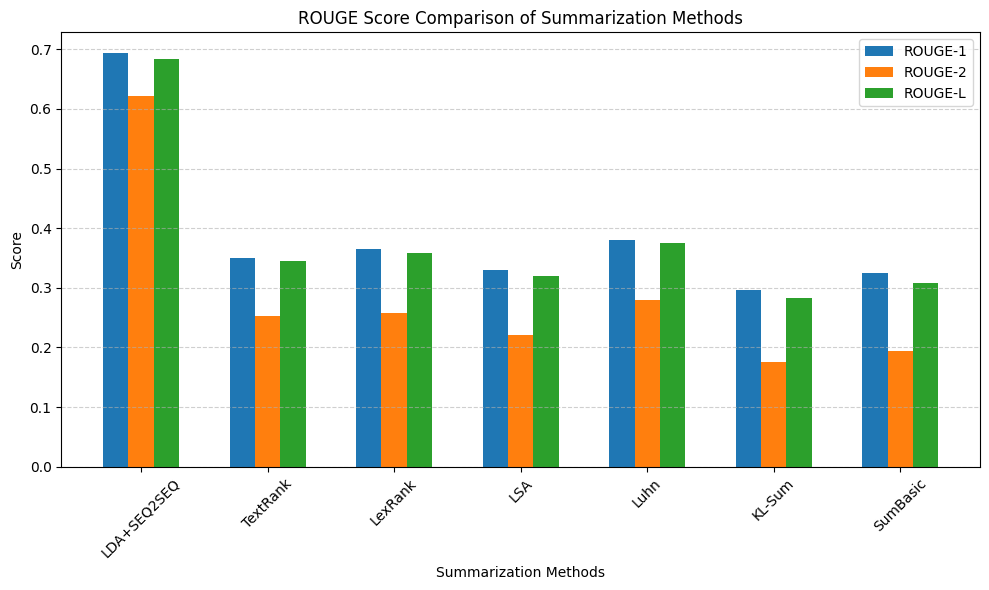

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data for only ROUGE-1, ROUGE-2, ROUGE-L
data = {
    'Method': ['LDA+SEQ2SEQ', 'TextRank', 'LexRank', 'LSA', 'Luhn', 'KL-Sum', 'SumBasic'],
    'ROUGE-1': [0.6939, 0.3507, 0.3657, 0.3294, 0.3794, 0.2969, 0.3255],
    'ROUGE-2': [0.6223, 0.2522, 0.2580, 0.2213, 0.2798, 0.1760, 0.1939],
    'ROUGE-L': [0.6836, 0.3452, 0.3582, 0.3200, 0.3753, 0.2837, 0.3087],
}

# Create DataFrame
df = pd.DataFrame(data)

# Setup
metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
methods = df['Method']
n_methods = len(methods)
bar_width = 0.2
index = np.arange(n_methods)

# Plot
plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    plt.bar(index + i * bar_width, df[metric], bar_width, label=metric)

# Labels and styling
plt.xlabel('Summarization Methods')
plt.ylabel('Score')
plt.title('ROUGE Score Comparison of Summarization Methods')
plt.xticks(index + bar_width, methods, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save and show
plt.savefig('rouge_score_comparison.png')
plt.show()


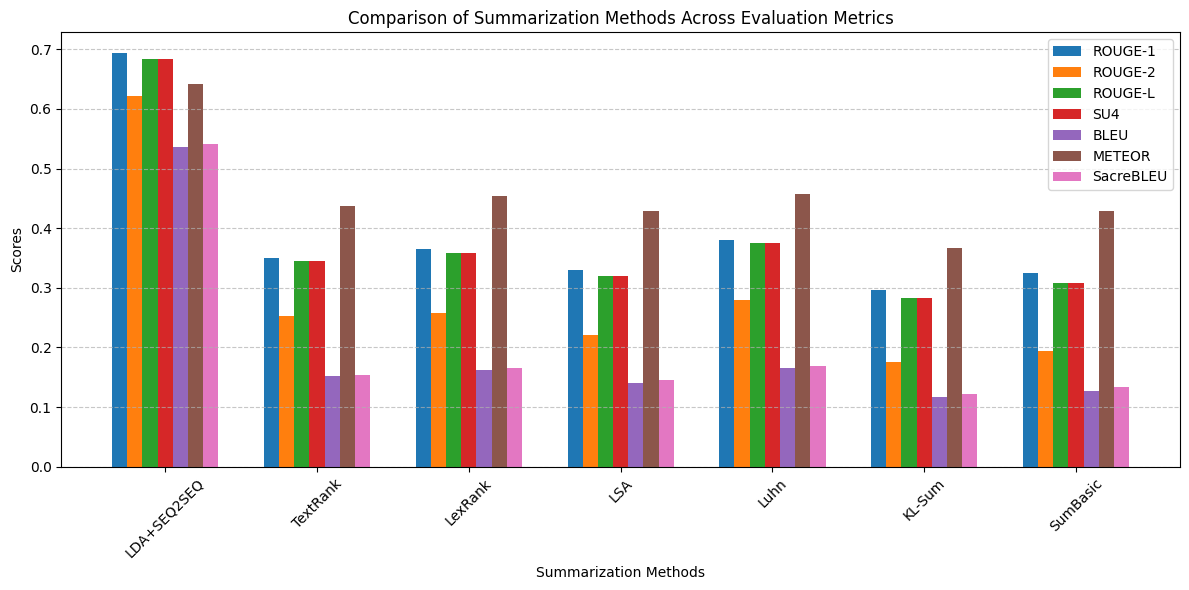

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data from the provided table
data = {
    'Method': ['LDA+SEQ2SEQ', 'TextRank', 'LexRank', 'LSA', 'Luhn', 'KL-Sum', 'SumBasic'],
    'ROUGE-1': [0.6939, 0.3507, 0.3657, 0.3294, 0.3794, 0.2969, 0.3255],
    'ROUGE-2': [0.6223, 0.2522, 0.2580, 0.2213, 0.2798, 0.1760, 0.1939],
    'ROUGE-L': [0.6836, 0.3452, 0.3582, 0.3200, 0.3753, 0.2837, 0.3087],
    'SU4': [0.6836, 0.3452, 0.3582, 0.3200, 0.3753, 0.2837, 0.3087],
    'BLEU': [0.5360, 0.1513, 0.1623, 0.1408, 0.1659, 0.1168, 0.1277],
    'METEOR': [0.6414, 0.4381, 0.4545, 0.4285, 0.4577, 0.3668, 0.4292],
    'SacreBLEU': [0.5411, 0.1542, 0.1658, 0.1448, 0.1689, 0.1213, 0.1339]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set up plot
metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'SU4', 'BLEU', 'METEOR', 'SacreBLEU']
methods = df['Method']
n_methods = len(methods)
n_metrics = len(metrics)
bar_width = 0.1
index = np.arange(n_methods)

# Create figure and axis
plt.figure(figsize=(12, 6))

# Plot bars for each metric
for i, metric in enumerate(metrics):
    plt.bar(index + i * bar_width, df[metric], bar_width, label=metric)

# Customize plot
plt.xlabel('Summarization Methods')
plt.ylabel('Scores')
plt.title('Comparison of Summarization Methods Across Evaluation Metrics')
plt.xticks(index + bar_width * (n_metrics - 1) / 2, methods, rotation=45)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save plot
plt.savefig('comparison_plot.png')

# Display plot
plt.show()

In [65]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from tqdm import tqdm

# Load Sentence-BERT model
model = SentenceTransformer("all-MiniLM-L6-v2")

# --- Metric Functions ---
def coherence_score(summary):
    sentences = summary.split('.')
    sentences = [s.strip() for s in sentences if s.strip()]
    if len(sentences) < 2:
        return 0
    embeddings = model.encode(sentences)
    similarities = [
        cosine_similarity([embeddings[i]], [embeddings[i + 1]])[0][0]
        for i in range(len(embeddings) - 1)
    ]
    return np.mean(similarities)

def redundancy_score(summary):
    sentences = summary.split('.')
    sentences = [s.strip() for s in sentences if s.strip()]
    if len(sentences) < 2:
        return 0
    embeddings = model.encode(sentences)
    sim_matrix = cosine_similarity(embeddings)
    n = len(sentences)
    return (np.sum(sim_matrix) - n) / (n * (n - 1)) if n > 1 else 0

def coverage_score(document, summary):
    doc_embedding = model.encode([document])[0]
    summary_embedding = model.encode([summary])[0]
    return cosine_similarity([summary_embedding], [doc_embedding])[0][0]

def relevance_score(doc_sentences, summary):
    summary_sentences = [s.strip() for s in summary.split('.') if s.strip()]
    if not summary_sentences or not doc_sentences:
        return 0
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(doc_sentences)
    sentence_scores = tfidf.sum(axis=1).A1
    top_indices = np.argsort(sentence_scores)[-5:]  # top 5 informative sentences
    top_sentences = [doc_sentences[i] for i in top_indices]
    top_embeddings = model.encode(top_sentences)
    summary_embeddings = model.encode(summary_sentences)
    scores = [cosine_similarity([s], top_embeddings).max() for s in summary_embeddings]
    return np.mean(scores)


In [66]:
coherence_scores = []
redundancy_scores = []
coverage_scores = []
relevance_scores = []

for i in tqdm(range(len(valid_test_sample))):
    article = test_sample["article"].iloc[i]
    doc_sentences = test_sample["sentence_tokenized"].iloc[i]
    summary = valid_test_sample["generated_summary"].iloc[i]

    coherence_scores.append(coherence_score(summary))
    redundancy_scores.append(redundancy_score(summary))
    coverage_scores.append(coverage_score(article, summary))
    relevance_scores.append(relevance_score(doc_sentences, summary))

# Convert to arrays
coherence_scores = np.array(coherence_scores)
redundancy_scores = np.array(redundancy_scores)
coverage_scores = np.array(coverage_scores)
relevance_scores = np.array(relevance_scores)

# Print average scores
print(f"\n✅ Average Coherence Score: {coherence_scores.mean():.4f}")
print(f"✅ Average Redundancy Score: {redundancy_scores.mean():.4f}")
print(f"✅ Average Coverage Score:   {coverage_scores.mean():.4f}")
print(f"✅ Average Relevance Score:  {relevance_scores.mean():.4f}")


100%|██████████| 804/804 [03:31<00:00,  3.80it/s]


✅ Average Coherence Score: 0.3233
✅ Average Redundancy Score: 0.3272
✅ Average Coverage Score:   0.7977
✅ Average Relevance Score:  0.6931
